In [1]:
import pandas as pd

import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.sql.types import DoubleType, StringType, IntegerType
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler, Imputer
from pyspark.sql.functions import count, when, col
from pyspark.sql.dataframe import DataFrame
from pyspark.ml.stat import Correlation
from pyspark.sql.window import Window
from pyspark.mllib.stat import Statistics
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.regression import RandomForestRegressor, GBTRegressor

from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.svm import OneClassSVM

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

import math
import numpy as np

In [2]:
def impute_median_by_group(data, feature, group_cols) -> DataFrame:

    median_window = Window.partitionBy(*group_cols)
    median_df = data.withColumn(
        f'{feature}_median', 
        F.expr(f'percentile_approx({feature}, 0.5)')
    ).over(median_window)

    # Impute the missing values using the calculated median
    imputed_data = median_df.withColumn(
        f'{feature}_median_by_provider', 
        F.when(F.col(feature).isNull(), F.col(f'{feature}_median'))
        .otherwise(F.col(feature))
    )

    imputed_data = imputed_data.drop(f'{feature}_median')
    return imputed_data

def impute_median(df, features):
    imputer = Imputer(
        inputCols=features, 
        outputCols=[f"{feat}_imputed" for feat in features],
        strategy="median"
    )

    df = imputer.fit(df).transform(df)
    return df


from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler


def kmeans_imputation(df, target_col, features, k=5):
    assembler = VectorAssembler(inputCols=features, outputCol="features")
    train_data = assembler.transform(df.filter(col(target_col).isNotNull()))
    predict_data = assembler.transform(df.filter(col(target_col).isNull()))

    # Train KMeans model on non-missing data
    kmeans = KMeans(k=k, featuresCol="features")
    model = kmeans.fit(train_data)

    # Predict the clusters for missing data
    predictions = model.transform(predict_data).select("prediction")

    # Impute based on the cluster centers
    cluster_centers = model.clusterCenters()

    # For each cluster, replace missing values with the mean/median of that cluster
    for i in range(k):
        cluster_value = cluster_centers[i][features.index(target_col)]
        predict_data = predict_data.withColumn(
            f"{target_col}_imputed",
            when(col("prediction") == i, cluster_value).otherwise(col(target_col))
        )

    return predict_data.drop("features", "prediction")


def impute_with_random_forest(df, target_col, features):
    # Separate data into training (non-missing target) and prediction (missing target)
    df = df.withColumn("row_id", F.monotonically_increasing_id())
    train_data = df.filter(df[target_col].isNotNull())
    predict_data = df.filter(df[target_col].isNull())

    # Assemble features
    assembler = VectorAssembler(inputCols=features, outputCol="features")
    train_data = assembler.transform(train_data)
    predict_data = assembler.transform(predict_data)

    # Train Random Forest Regressor
    rf = RandomForestRegressor(featuresCol="features", labelCol=target_col, numTrees=100)
    rf_model = rf.fit(train_data)

    predictions = rf_model.transform(predict_data).select("row_id", "prediction")
    imputed_data = df.join(predictions, on="row_id", how="left").drop("row_id")
    imputed_data = imputed_data.withColumn(
        f"{target_col}_imputed",
        when(col(target_col).isNull(), col("prediction")).otherwise(col(target_col))
    ).drop("prediction")
    return imputed_data

In [3]:
from scipy.stats import ks_2samp

def ks_test(df, feat1, feat2):
    """
    The Kolmogorov-Smirnov (KS) test is used to compare two distributions to see if they are significantly different from each other. 
    It calculates a test statistic, which represents the maximum difference between the cumulative distributions of the two samples, 
    and a p-value, which indicates whether this difference is statistically significant.
    """
    original_values = df.filter(F.col(feat1).isNotNull()).select(feat1).toPandas()
    imputed_values = df.select(feat2).toPandas()

    ks_stat, p_value = ks_2samp(original_values[feat1], imputed_values[feat2])
    print(f"KS Test Statistic: {ks_stat}, p-value: {p_value}")

def cap_outliers_zscore(df, feature, z_threshold=3):
    """
    Cap outliers of a specific feature using the Z-score method.
    
    Parameters:
    - df: PySpark DataFrame
    - feature: The name of the feature (column) to cap outliers
    - z_threshold: The Z-score threshold beyond which values will be capped (default is 3)
    
    Returns:
    - DataFrame with the outliers capped
    """
    # Calculate mean and standard deviation for the feature
    mean_val = df.select(F.mean(F.col(feature))).first()[0]
    stddev_val = df.select(F.stddev(F.col(feature))).first()[0]
    
    # Define the upper and lower limits using the Z-score threshold
    upper_limit = mean_val + z_threshold * stddev_val
    lower_limit = mean_val - z_threshold * stddev_val
    
    # Cap the values outside the limits
    capped_df = df.withColumn(
        f"{feature}_capped",
        F.when(F.col(feature) > upper_limit, upper_limit)
         .when(F.col(feature) < lower_limit, lower_limit)
         .otherwise(F.col(feature))
    )
    
    return capped_df

In [4]:
def stratified_split(df, ratios: list=[0.8, 0.2], target_col: str='label'):
  pos = df.filter(F.col(target_col)==1)
  neg = df.filter(F.col(target_col)==0)
  
  train_pos, test_pos = pos.randomSplit(ratios, seed=SEED)
  train_neg, test_neg = neg.randomSplit(ratios, seed=SEED)
  
  return train_pos.union(train_neg), test_pos.union(test_neg)

def calculate_class_distribution(df, label_col="chargeback"):
    distribution = df.groupBy(label_col).count()
    total = df.count()
    distribution = distribution.withColumn("percentage", (distribution["count"] / total) * 100)
    return distribution


def calculate_profit(y_true, y_pred, transaction_amounts):
    total_profit = 0.0
    total_loss = 0.0
    
    # Iterar sobre todas as transações
    for true_label, pred_label, amount in zip(y_true, y_pred, transaction_amounts):
        if true_label == 0 and pred_label == 0:
            # Transação corretamente prevista sem chargeback - lucro de 15% do valor da transação
            total_profit += 0.15 * amount
        elif true_label == 1 and pred_label == 0:
            # Falso negativo (fraude não detectada) - perda total do valor da transação
            total_loss += amount
    
    net_profit = total_profit - total_loss
    return net_profit

In [5]:
def missing_analysis(df, feature, group_col):
    # Calculate the percentage of missing values grouped by 'group_col'
    missing_by_group = (
        df
        .groupBy(group_col)
        .agg(
            (F.sum(F.when(F.col(feature).isNull(), 1).otherwise(0)) / F.count("*")).alias("missing_percentage")
        )
        .toPandas()
    )

    print(f"Missing value percentage grouped by {group_col}:")
    display(missing_by_group)

def calculate_stats(df, feature, group_col):
    # Calculate the basic statistics
    statistics = (
        df.groupBy(group_col)
        .agg(
            F.count(feature).alias("count"),
            F.mean(feature).alias("mean"),
            F.stddev(feature).alias("stddev"),
            F.min(feature).alias("min"),
            F.expr(f"percentile_approx({feature}, 0.25)").alias("25%"),
            F.expr(f"percentile_approx({feature}, 0.5)").alias("median"),
            F.expr(f"percentile_approx({feature}, 0.75)").alias("75%"),
            F.expr(f"percentile_approx({feature}, 0.99)").alias("99%"),
            F.max(feature).alias("max")
        )
    )

    return statistics

def plot_feature_distribution(df, feature):
    data_to_check = df.select(feature, "chargeback").toPandas()
    data_to_check['chargeback'] = data_to_check['chargeback'].astype(int)

    plt.figure(figsize=(10, 6))
    sns.kdeplot(
        data=data_to_check[data_to_check['chargeback'] == 0][feature], 
        label='No Chargeback', 
        fill=True
    )
    sns.kdeplot(
        data=data_to_check[data_to_check['chargeback'] == 1][feature], 
        label='Chargeback', 
        fill=True
    )
    plt.title(f'Density Plot of `{feature}` for Chargeback and No Chargeback')
    plt.xlabel(f'Number of {feature}')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

In [6]:
SEED = 12345

**What is the problem?** 

Approved transactions may generate chargebacks (total loss of value) or not (generating 15% of revenue). The goal is to develop a solution to prevent chargebacks and maximize profitability.

**What is the specific objectives?**

- Develop a model to predict chargebacks on transactions.
- Compare the performance of the solution with the other two providers.
- Evaluate the solution based on appropriate methodologies.

In [7]:
DATA_PATH = "/home/arthur/Documents/data-ds-case-23.parquet"

In [8]:
# Create a Spark session
spark = SparkSession.builder \
    .appName("Incognia Chargeback Analysis") \
    .config("spark.driver.memory", "15g") \
    .getOrCreate()

24/10/12 20:04:54 WARN Utils: Your hostname, arthur-Dell-G15-5511 resolves to a loopback address: 127.0.1.1; using 192.168.1.6 instead (on interface wlp0s20f3)
24/10/12 20:04:54 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/12 20:04:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [9]:
# Read data
raw_data = spark.read.parquet(DATA_PATH)

# As said in the document, we can assume that all transactions were approved.
raw_data = raw_data.drop("status")

In [10]:
original_categorical_features = ['id', 'device_id', 'account_id', 'installation_id', 'f_os', 'chargeback', 'provider']
original_numerical_features = [
    'total_amount', 'f_boot_count', 'f_wallpaper_id', 'f_chargeback_rate_by_geohash_5_30d', 'f_chargeback_rate_by_geohash_6_30d', 
    'f_chargeback_rate_by_geohash_7_30d', 'f_sum_values_by_ilm_id_30d', 'f_sum_values_by_ilm_id_3d', 'f_device_age_ms', 'f_account_age_ms',
    'f_sum_values_by_device_id_30d', 'f_sum_values_by_device_id_3d', 'f_n_user_ids_by_device_id_30d', 'f_n_installations_by_device_id_30d',
    'f_total_events', 'f_total_installations', 'f_total_fraud_installations', 'f_total_fraud_events', 'f_avg_fraud_installations', 'f_avg_fraud_events'
]
original_timestamp_features = ["dt", "timestamp"]

# Analyzing missing data

In [11]:
def check_missing_values(data) -> dict:
    missing_values = {} 

    for index, column in enumerate(data.columns):
        missing_count = data.filter(col(column).isNull()).count()
        missing_values.update({column: missing_count / data.count()})
    
    return missing_values

In [12]:
missing_values = check_missing_values(raw_data)

In [13]:
missing_values

{'dt': 0.0,
 'id': 0.0,
 'device_id': 0.0,
 'account_id': 0.0,
 'installation_id': 0.0,
 'timestamp': 0.0,
 'total_amount': 0.0,
 'f_boot_count': 0.37978619432694233,
 'f_wallpaper_id': 0.3797887099837614,
 'f_chargeback_rate_by_geohash_5_30d': 0.11829247277744864,
 'f_chargeback_rate_by_geohash_6_30d': 0.11923835974144079,
 'f_chargeback_rate_by_geohash_7_30d': 0.13286064141701917,
 'f_sum_values_by_ilm_id_30d': 0.711396302739173,
 'f_sum_values_by_ilm_id_3d': 0.7114227171357738,
 'f_device_age_ms': 0.0,
 'f_account_age_ms': 0.0,
 'f_os': 0.0,
 'f_sum_values_by_device_id_30d': 0.65309721378429,
 'f_sum_values_by_device_id_3d': 0.6531009872695187,
 'f_n_user_ids_by_device_id_30d': 0.18699002919419738,
 'f_n_installations_by_device_id_30d': 0.18682273801572538,
 'f_total_events': 0.5338412444451153,
 'f_total_installations': 0.5338412444451153,
 'f_total_fraud_installations': 0.5338412444451153,
 'f_total_fraud_events': 0.5338412444451153,
 'f_avg_fraud_installations': 0.533841244445115

<Axes: >

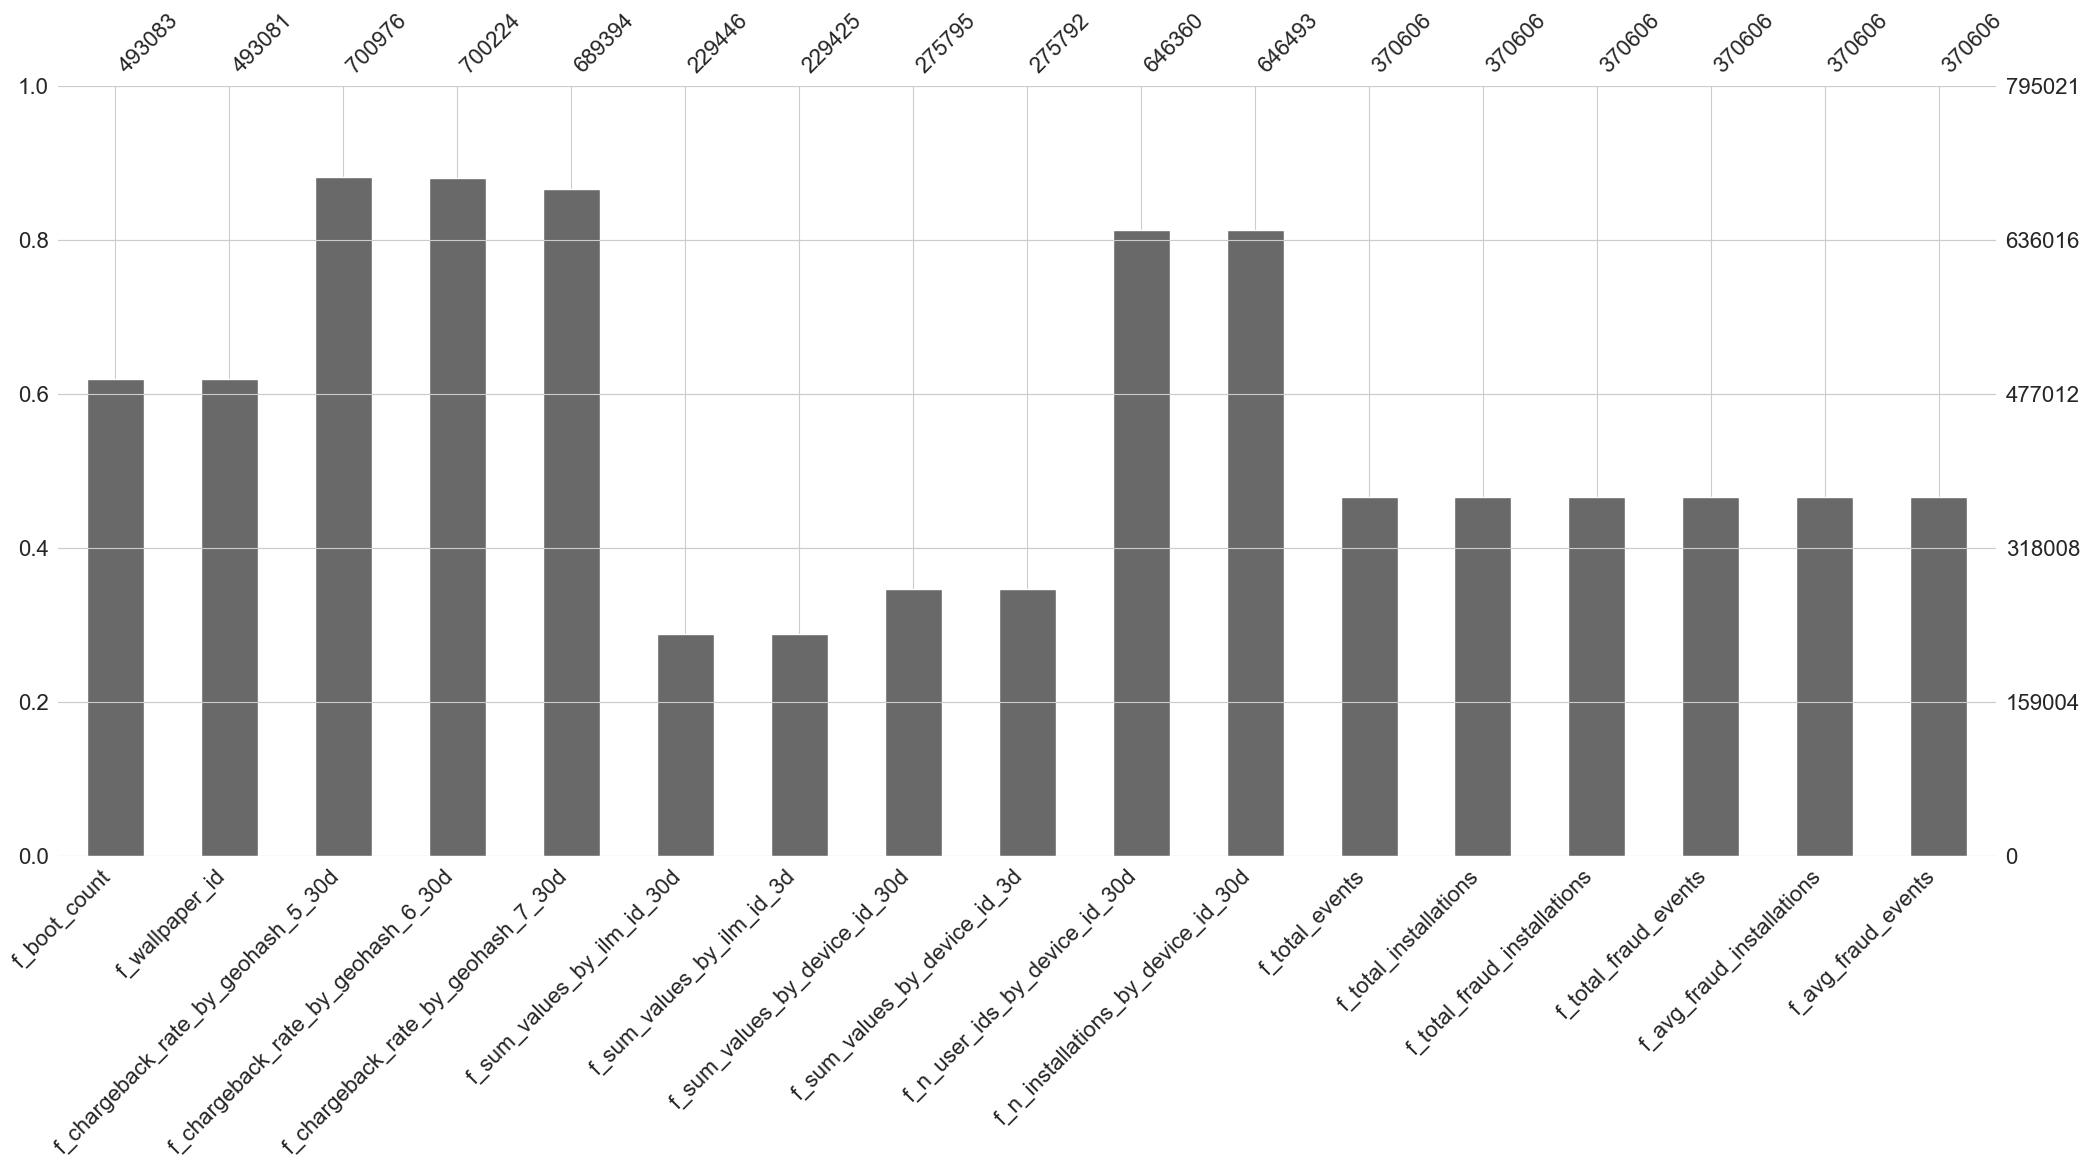

In [15]:
import missingno as msno


missing_columns = [column for column, value in missing_values.items() if value > 0]
missing_data_pd = raw_data.select(missing_columns).toPandas()
msno.bar(missing_data_pd)

- Features like `dt`, `id`, `device_id`, `account_id`, `installation_id`, `timestamp`, `total_amount`, `f_device_age_ms`, `f_account_age_ms`, `f_os`, and `provider` show no missing values.
- `f_boot_count` and `f_wallpaper_id` have about 38% missing values.
- Geographic features such as `f_chargeback_rate_by_geohash_5_30d`, `f_chargeback_rate_by_geohash_6_30d`, and `f_chargeback_rate_by_geohash_7_30d` show approximately 87-88% non-null values, meaning that around 12-13% of the data is missing for these features.
- `f_n_user_ids_by_device_id_30d` and `f_n_installations_by_device_id_30d` both show roughly 81-82% non-null values.

**Significant Missing Data:**
- Features like `f_sum_values_by_ilm_id_30d`, `f_sum_values_by_ilm_id_3d`, `f_sum_values_by_device_id_30d`, and `f_sum_values_by_device_id_3d` exhibit a high proportion of missing data, with around 65-71% of their values absent.
- Features related to fraud detection, such as `f_total_events`, `f_total_installations`, `f_total_fraud_installations`, `f_total_fraud_events`, `f_avg_fraud_installations`, and `f_avg_fraud_events`, have nearly 53% null values.

<Axes: >

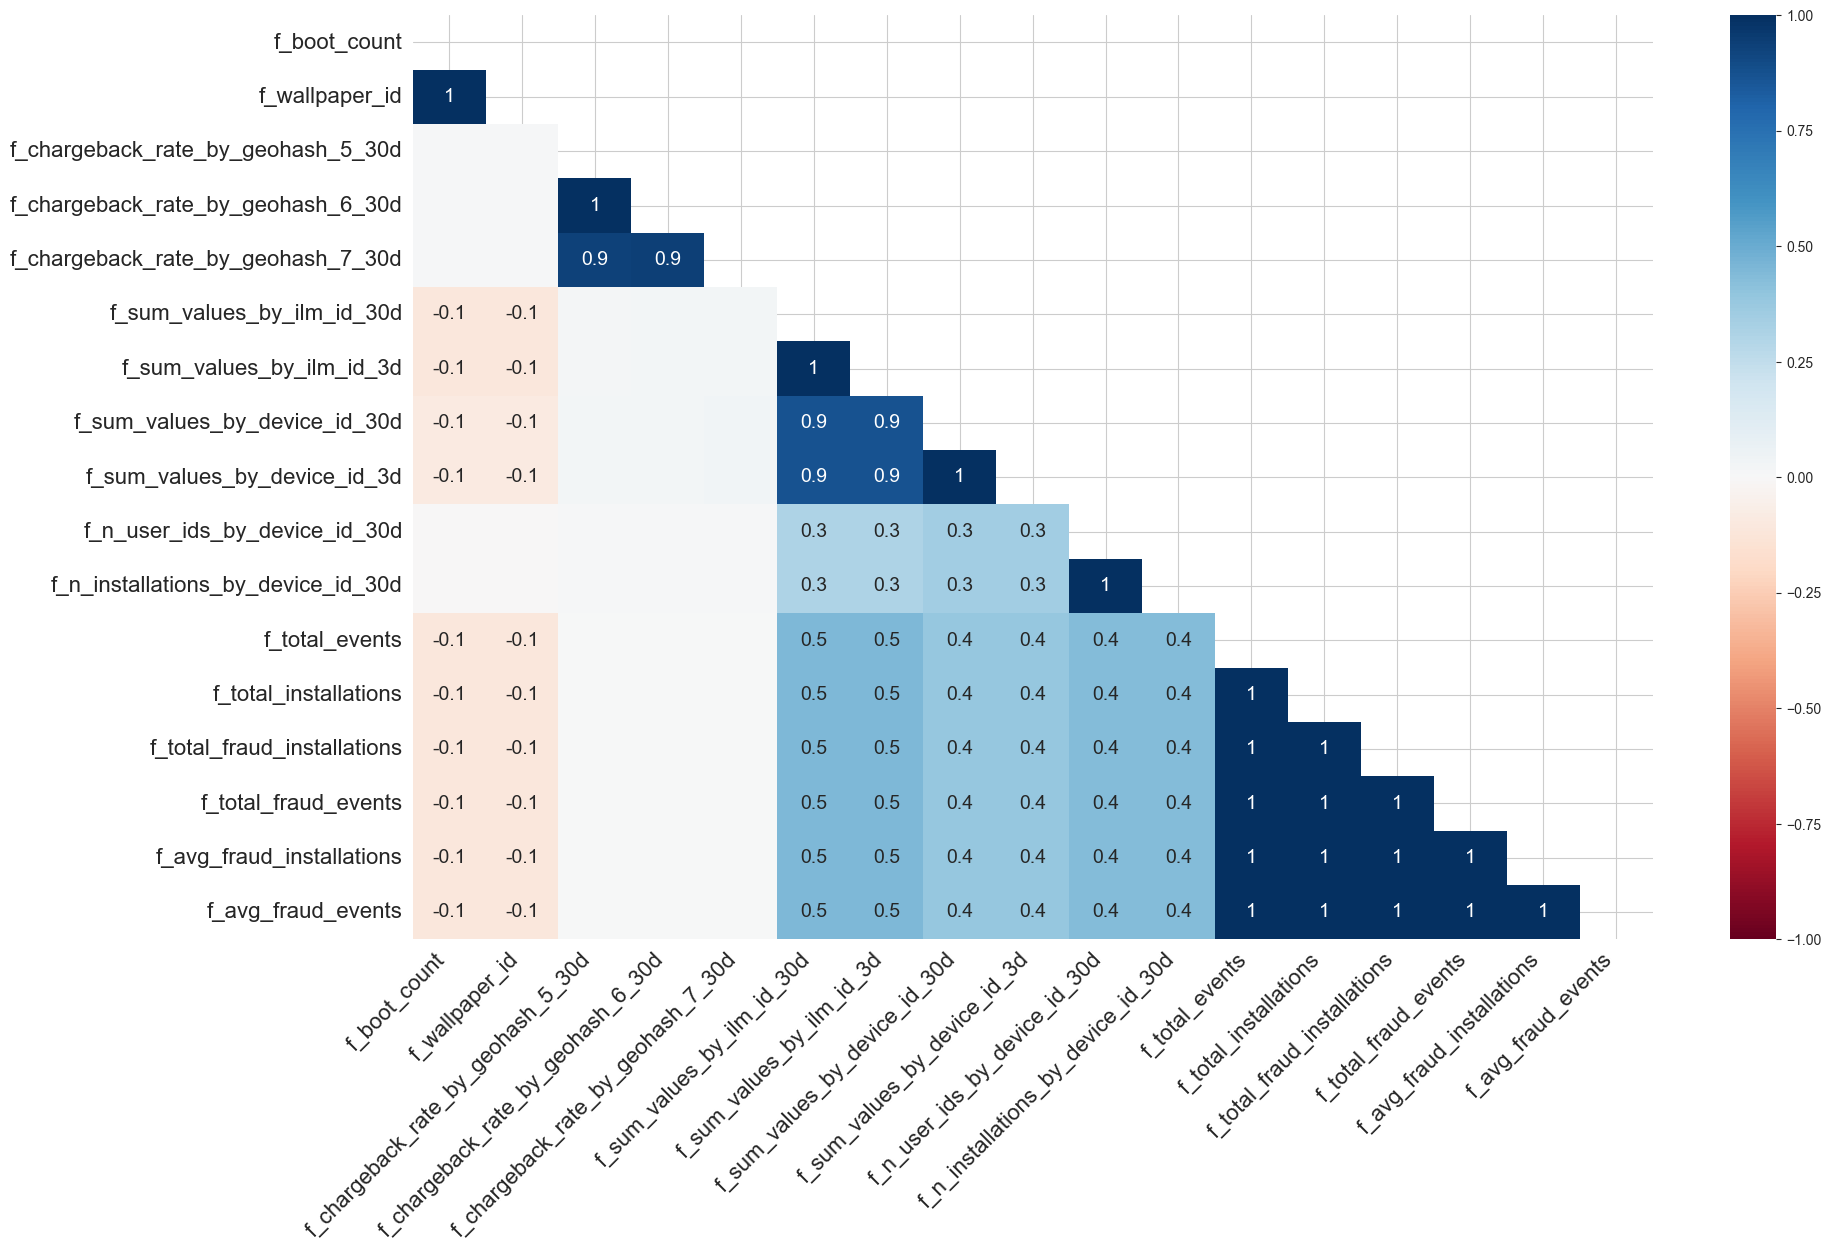

In [16]:
msno.heatmap(missing_data_pd)

The figures above provides a visual representation of the missing data patterns across the dataset's features.

- The fraud-related features (`f_total_fraud_installations`, `f_total_fraud_events`, `f_avg_fraud_installations`, `f_avg_fraud_events`) have perfect correlations (1.0) with each other. This means that whenever one of these columns has missing values, the others will also have missing values (MNAR).
- Similarly, there is a high correlation between `f_sum_values_by_device_id_30d` and `f_sum_values_by_device_id_3d`, indicating that the missing values in these features often occur together.
- The features representing geographic chargeback rates (`f_chargeback_rate_by_geohash_5_30d`, `f_chargeback_rate_by_geohash_6_30d`, `f_chargeback_rate_by_geohash_7_30d`) also exhibit strong correlations in their missing values (around 0.9).
- Some moderate correlations (around 0.3 to 0.5) exist between missing values in `f_n_user_ids_by_device_id_30d`, `f_n_installations_by_device_id_30d`, and some fraud-related features like `f_total_events` and `f_total_installations`. This implies that, although not perfectly, missing values in one set of features (related to device IDs) are somewhat associated with missing values in fraud-related features.
- Some of the features, such as `f_boot_count` and `f_wallpaper_id`, show very low correlations with missing values in other columns. This suggests that their missing values are likely independent and do not follow the same pattern as other features (MCAR).

In [12]:
cleaned_data = raw_data.alias("cleaned_data")

# Data Cleaning

### Number of times the device has been rebooted

In [13]:
missing_analysis(cleaned_data, "f_boot_count", "chargeback")
stats = calculate_stats(cleaned_data, "f_boot_count", "chargeback")
stats.show()

Missing value percentage grouped by chargeback:


,chargeback,missing_percentage
0,True,0.396483
1,False,0.379398


+----------+------+------------------+------------------+---+---+------+---+----+-----+
|chargeback| count|              mean|            stddev|min|25%|median|75%| 99%|  max|
+----------+------+------------------+------------------+---+---+------+---+----+-----+
|      true| 10914|175.52308960967565|277.90489231841383|  1| 20|    79|207|1319| 3983|
|     false|482169|162.25619233090472| 290.4403752892912|  1| 21|    68|181|1367|29766|
+----------+------+------------------+------------------+---+---+------+---+----+-----+



In [15]:
missing_analysis(cleaned_data, "f_boot_count", "provider")
stats = calculate_stats(cleaned_data, "f_boot_count", "provider")
stats.show()

Missing value percentage grouped by provider:


,provider,missing_percentage
0,YOU,0.386610
1,EXTERNAL_2,0.388505
2,EXTERNAL_1,0.376049


+----------+------+------------------+------------------+---+---+------+---+----+-----+
|  provider| count|              mean|            stddev|min|25%|median|75%| 99%|  max|
+----------+------+------------------+------------------+---+---+------+---+----+-----+
|       YOU| 43060| 158.9468648397585|276.74990700933284|  1| 23|    67|177|1339| 6306|
|EXTERNAL_2|109465| 167.2804640752752| 302.3290879272663|  1| 22|    70|186|1415|10431|
|EXTERNAL_1|340558|161.48484839586797|287.81890881807635|  1| 21|    67|181|1350|29766|
+----------+------+------------------+------------------+---+---+------+---+----+-----+



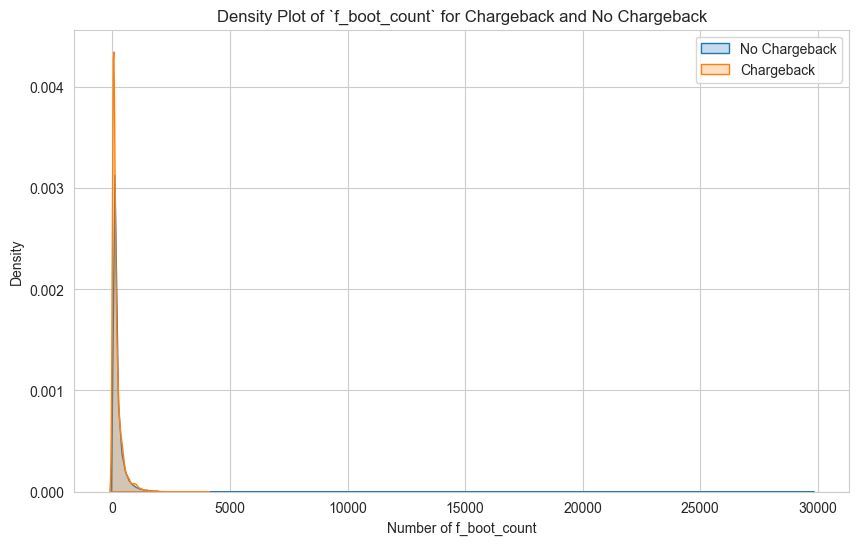

In [16]:
plot_feature_distribution(cleaned_data, "f_boot_count")

The distribution of the `f_boot_count` feature is heavily skewed to the right, with most values concentrated at the lower end. This indicates that a majority of devices have relatively low boot counts, with a small number of devices experiencing an unusually high number of reboots.

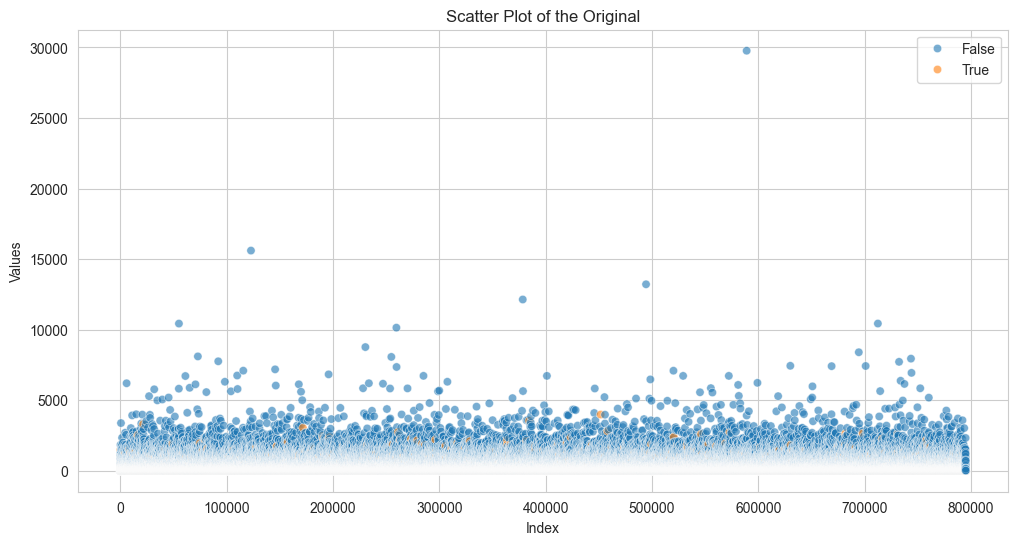

In [20]:
# Assuming you have a DataFrame named 'pandas_df' with original and imputed columns
pandas_df = cleaned_data.select("f_boot_count", "chargeback").toPandas()
original_values = pandas_df["f_boot_count"]

# Create a scatter plot
plt.figure(figsize=(12, 6))
sns.scatterplot(data=pandas_df, x=pandas_df.index, y="f_boot_count", hue="chargeback", alpha=0.6)

# Set plot labels and title
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Scatter Plot of the Original')
plt.legend()
plt.show()

In [80]:
cleaned_data = impute_median(
    cleaned_data, 
    ["f_boot_count"]
)

#### Outlier Detection + Imputation

In [71]:
cleaned_data = cap_outliers_zscore(cleaned_data, "f_boot_count_imputed", 25)

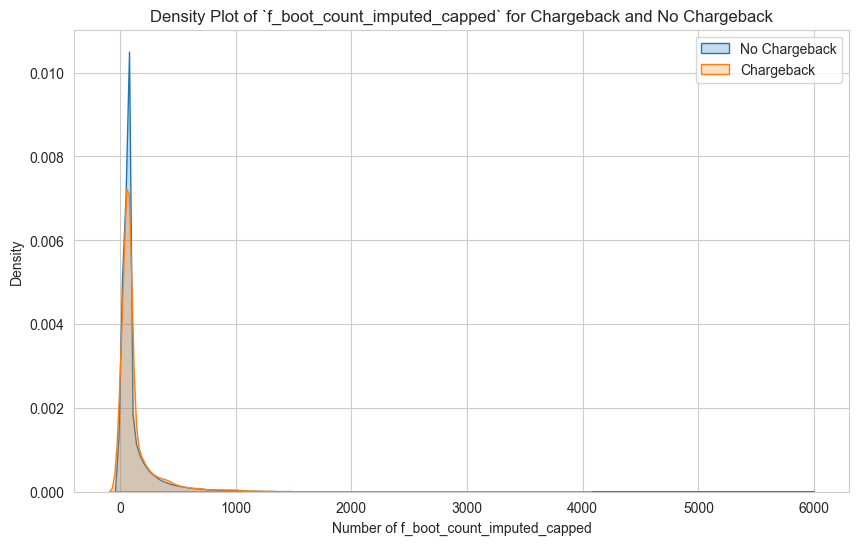

In [72]:
plot_feature_distribution(cleaned_data, "f_boot_count_imputed_capped")

In [73]:
summary_stats = cleaned_data.selectExpr(
    "percentile_approx(f_boot_count, 0.5) as median_original",
    "percentile_approx(f_boot_count_imputed_capped, 0.5) as median_imputed",
    "mean(f_boot_count) as mean_original",
    "mean(f_boot_count_imputed_capped) as mean_imputed",
    "stddev(f_boot_count) as stddev_original",
    "stddev(f_boot_count_imputed_capped) as stddev_imputed",
    "max(f_boot_count) as max_original",
    "max(f_boot_count_imputed_capped) as max_imputed",
    "min(f_boot_count) as min_original",
    "min(f_boot_count_imputed_capped) as min_imputed",
).show()

+---------------+--------------+------------------+------------------+------------------+------------------+------------+-----------------+------------+-----------+
|median_original|median_imputed|     mean_original|      mean_imputed|   stddev_original|    stddev_imputed|max_original|      max_imputed|min_original|min_imputed|
+---------------+--------------+------------------+------------------+------------------+------------------+------------+-----------------+------------+-----------+
|             68|          68.0|162.54984454949775|126.52248186645102|290.17506703259585|227.73511228232113|       29766|5953.768742970627|           1|        1.0|
+---------------+--------------+------------------+------------------+------------------+------------------+------------+-----------------+------------+-----------+



In [75]:
from scipy.stats import energy_distance

# Assuming original_values and imputed_values are your samples from the original and imputed distributions
pandas_df = cleaned_data.select("f_boot_count", "f_boot_count_imputed").toPandas()
original_values = pandas_df["f_boot_count"].dropna()
imputed_values = pandas_df["f_boot_count_imputed"]

# Calculate the energy distance
energy_dist = energy_distance(original_values, imputed_values)
print(f"Energy Distance: {energy_dist}")

Energy Distance: 2.958828549053128


### Chargeback rate by geographic region in the last 30 days

In [19]:
missing_analysis(cleaned_data, "f_chargeback_rate_by_geohash_5_30d", "chargeback")

Missing value percentage grouped by chargeback:


,chargeback,missing_percentage
0,True,0.116235
1,False,0.118340


In [21]:
stats = calculate_stats(cleaned_data, "f_chargeback_rate_by_geohash_5_30d", "chargeback")
stats.show()

+----------+------+--------------------+--------------------+---+------------+------------+------------+------------+-----------+
|chargeback| count|                mean|              stddev|min|         25%|      median|         75%|         99%|        max|
+----------+------+--------------------+--------------------+---+------------+------------+------------+------------+-----------+
|      true| 15982|7.260902962041258E-4|0.001168994065060...|0.0|1.9852284E-4|4.3484502E-4|  8.50108E-4|0.0050831432|0.024650212|
|     false|684994|4.906076102653079E-4|0.001138642729603...|0.0|1.1039376E-4| 2.762785E-4|5.6727947E-4| 0.003614754| 0.34495616|
+----------+------+--------------------+--------------------+---+------------+------------+------------+------------+-----------+



In [121]:
missing_analysis(cleaned_data, "f_chargeback_rate_by_geohash_5_30d", "provider")

Missing value percentage grouped by provider:


,provider,missing_percentage
0,YOU,0.109074
1,EXTERNAL_2,0.121048
2,EXTERNAL_1,0.118574


In [22]:
stats = calculate_stats(cleaned_data, "f_chargeback_rate_by_geohash_5_30d", "provider")
stats.show()

+----------+------+--------------------+--------------------+---+-------------+------------+------------+------------+----------+
|  provider| count|                mean|              stddev|min|          25%|      median|         75%|         99%|       max|
+----------+------+--------------------+--------------------+---+-------------+------------+------------+------------+----------+
|       YOU| 62543|4.218942316183666...|7.368968788605808E-4|0.0|1.00395366E-4|2.5241848E-4|  5.05249E-4|0.0029323928|0.04401745|
|EXTERNAL_2|157343| 5.16304175884919E-4|0.001347112291973...|0.0| 1.1249311E-4|2.8431966E-4|5.8602815E-4|0.0038984392| 0.3224637|
|EXTERNAL_1|481090|4.989591669451462E-4|0.001108265723326...|0.0| 1.1347102E-4|2.8198998E-4|5.7639537E-4|0.0037059197|0.34495616|
+----------+------+--------------------+--------------------+---+-------------+------------+------------+------------+----------+



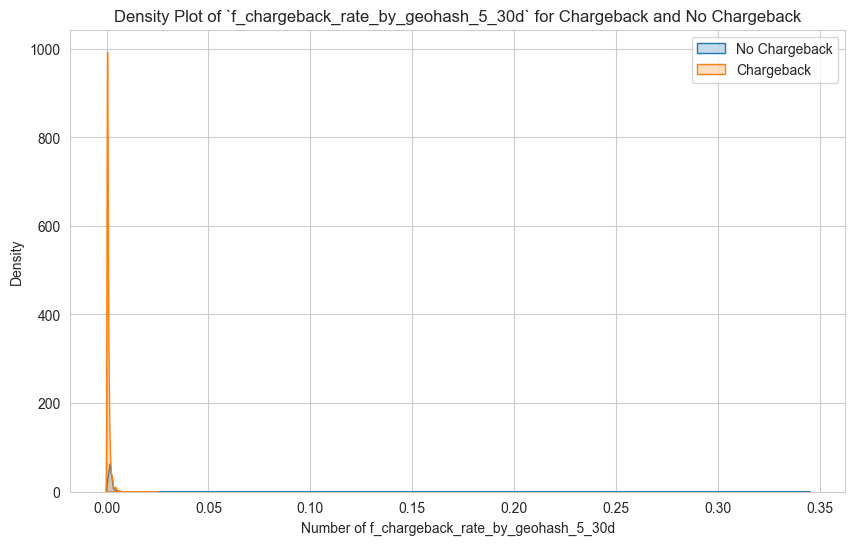

In [23]:
plot_feature_distribution(cleaned_data, "f_chargeback_rate_by_geohash_5_30d")

In [26]:
cleaned_data = impute_median(
    cleaned_data, 
    ["f_chargeback_rate_by_geohash_5_30d", "f_chargeback_rate_by_geohash_6_30d", "f_chargeback_rate_by_geohash_7_30d"]
)

/home/arthur/miniconda3/envs/case-ds/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


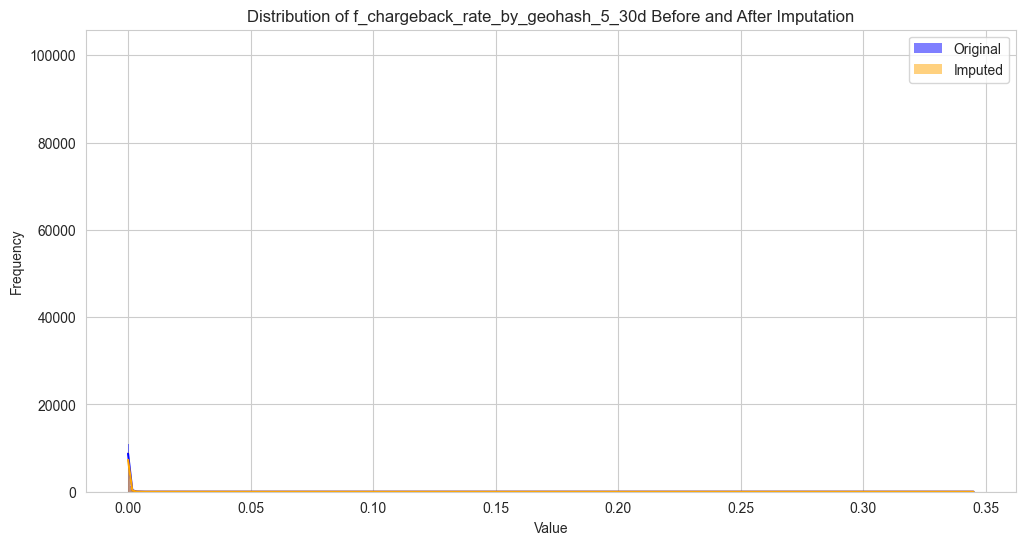

In [33]:
# Convert to Pandas for plotting
pandas_df = cleaned_data.select("f_chargeback_rate_by_geohash_5_30d", "f_chargeback_rate_by_geohash_5_30d_imputed").toPandas()

# Plot original vs. imputed distributions
plt.figure(figsize=(12, 6))
sns.histplot(pandas_df["f_chargeback_rate_by_geohash_5_30d"].dropna(), label="Original", kde=True, color='blue')
sns.histplot(pandas_df["f_chargeback_rate_by_geohash_5_30d_imputed"], label="Imputed", kde=True, color='orange')
plt.legend()
plt.title("Distribution of f_chargeback_rate_by_geohash_5_30d Before and After Imputation")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

In [34]:
summary_stats = cleaned_data.selectExpr(
    "percentile_approx(f_chargeback_rate_by_geohash_5_30d, 0.5) as median_original",
    "percentile_approx(f_chargeback_rate_by_geohash_5_30d_imputed, 0.5) as median_imputed",
    "mean(f_chargeback_rate_by_geohash_5_30d) as mean_original",
    "mean(f_chargeback_rate_by_geohash_5_30d_imputed) as mean_imputed",
    "stddev(f_chargeback_rate_by_geohash_5_30d) as stddev_original",
    "stddev(f_chargeback_rate_by_geohash_5_30d_imputed) as stddev_imputed"
).show()

+---------------+--------------+-------------------+--------------------+--------------------+--------------------+
|median_original|median_imputed|      mean_original|        mean_imputed|     stddev_original|      stddev_imputed|
+---------------+--------------+-------------------+--------------------+--------------------+--------------------+
|    2.796622E-4|   2.790699E-4|4.95976530580232E-4|4.703181097464410...|0.001139884935513...|0.001072633553645...|
+---------------+--------------+-------------------+--------------------+--------------------+--------------------+



In [51]:
ks_test(cleaned_data, "f_chargeback_rate_by_geohash_5_30d", "f_chargeback_rate_by_geohash_5_30d_imputed")

KS Test Statistic: 0.05921306295514006, p-value: 0.0


The distribution of the imputed feature (`f_chargeback_rate_by_geohash_5_30d`) is statistically indistinguishable from the original non-missing values. This implies that the imputation method has maintained the original distribution of the data well, and there is no indication of a significant shift in the distribution after imputing the missing values.

In [48]:
summary_stats = cleaned_data.selectExpr(
    "percentile_approx(f_chargeback_rate_by_geohash_6_30d, 0.5) as median_original",
    "percentile_approx(f_chargeback_rate_by_geohash_6_30d_imputed, 0.5) as median_imputed",
    "mean(f_chargeback_rate_by_geohash_6_30d) as mean_original",
    "mean(f_chargeback_rate_by_geohash_6_30d_imputed) as mean_imputed",
    "stddev(f_chargeback_rate_by_geohash_6_30d) as stddev_original",
    "stddev(f_chargeback_rate_by_geohash_6_30d_imputed) as stddev_imputed",
    "max(f_chargeback_rate_by_geohash_6_30d) as max_original",
    "max(f_chargeback_rate_by_geohash_6_30d_imputed) as max_imputed",
    "min(f_chargeback_rate_by_geohash_6_30d) as min_original",
    "min(f_chargeback_rate_by_geohash_6_30d_imputed) as min_imputed",
).show()

+---------------+--------------+--------------------+--------------------+--------------------+--------------------+------------+-----------+------------+-----------+
|median_original|median_imputed|       mean_original|        mean_imputed|     stddev_original|      stddev_imputed|max_original|max_imputed|min_original|min_imputed|
+---------------+--------------+--------------------+--------------------+--------------------+--------------------+------------+-----------+------------+-----------+
|            0.0|           0.0|5.733294432473085E-4|5.049665808430259E-4|0.003209317842260...|0.003017634608902253|   0.6006245|  0.6006245|         0.0|        0.0|
+---------------+--------------+--------------------+--------------------+--------------------+--------------------+------------+-----------+------------+-----------+



In [49]:
summary_stats = cleaned_data.selectExpr(
    "percentile_approx(f_chargeback_rate_by_geohash_7_30d, 0.5) as median_original",
    "percentile_approx(f_chargeback_rate_by_geohash_7_30d_imputed, 0.5) as median_imputed",
    "mean(f_chargeback_rate_by_geohash_7_30d) as mean_original",
    "mean(f_chargeback_rate_by_geohash_7_30d_imputed) as mean_imputed",
    "stddev(f_chargeback_rate_by_geohash_7_30d) as stddev_original",
    "stddev(f_chargeback_rate_by_geohash_7_30d_imputed) as stddev_imputed",
    "max(f_chargeback_rate_by_geohash_7_30d) as max_original",
    "max(f_chargeback_rate_by_geohash_7_30d_imputed) as max_imputed",
    "min(f_chargeback_rate_by_geohash_7_30d) as min_original",
    "min(f_chargeback_rate_by_geohash_7_30d_imputed) as min_imputed",
).show()

+---------------+--------------+--------------------+--------------------+--------------------+------------------+------------+-----------+------------+-----------+
|median_original|median_imputed|       mean_original|        mean_imputed|     stddev_original|    stddev_imputed|max_original|max_imputed|min_original|min_imputed|
+---------------+--------------+--------------------+--------------------+--------------------+------------------+------------+-----------+------------+-----------+
|            0.0|           0.0|6.729616660686804E-4|5.835515474657296E-4|0.009844819559151112|0.0091703716030149|         1.0|        1.0|         0.0|        0.0|
+---------------+--------------+--------------------+--------------------+--------------------+------------------+------------+-----------+------------+-----------+



In [60]:
from scipy.stats import energy_distance

# Assuming original_values and imputed_values are your samples from the original and imputed distributions
pandas_df = cleaned_data.select("f_chargeback_rate_by_geohash_7_30d", "f_chargeback_rate_by_geohash_7_30d_imputed").toPandas()
original_values = pandas_df["f_chargeback_rate_by_geohash_7_30d"].dropna()
imputed_values = pandas_df["f_chargeback_rate_by_geohash_7_30d_imputed"]

# Calculate the energy distance
energy_dist = energy_distance(original_values, imputed_values)
print(f"Energy Distance: {energy_dist}")

Energy Distance: 0.0004469658084049425


### Number of users per device in the last 30 days. 

In [61]:
missing_analysis(cleaned_data, "f_n_user_ids_by_device_id_30d", "chargeback")

Missing value percentage grouped by chargeback:


,chargeback,missing_percentage
0,True,0.117175
1,False,0.188615


In [63]:
stats = calculate_stats(cleaned_data, "f_n_user_ids_by_device_id_30d", "chargeback")
stats.show()

+----------+------+------------------+------------------+---+---+------+---+---+---+
|chargeback| count|              mean|            stddev|min|25%|median|75%|99%|max|
+----------+------+------------------+------------------+---+---+------+---+---+---+
|      true| 15965|1.1515815847165676|0.8311905679639487|  0|  1|     1|  1|  5| 16|
|     false|630395|1.0674148748007202| 1.050632533690403|  0|  1|     1|  1|  5| 86|
+----------+------+------------------+------------------+---+---+------+---+---+---+



In [64]:
missing_analysis(cleaned_data, "f_n_user_ids_by_device_id_30d", "provider")

Missing value percentage grouped by provider:


,provider,missing_percentage
0,YOU,0.149858
1,EXTERNAL_2,0.169760
2,EXTERNAL_1,0.197417


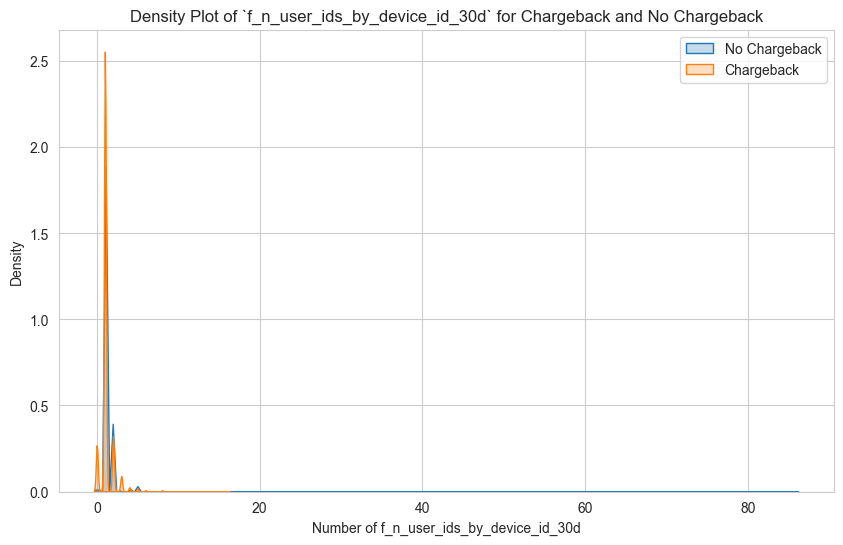

In [65]:
plot_feature_distribution(cleaned_data, "f_n_user_ids_by_device_id_30d")

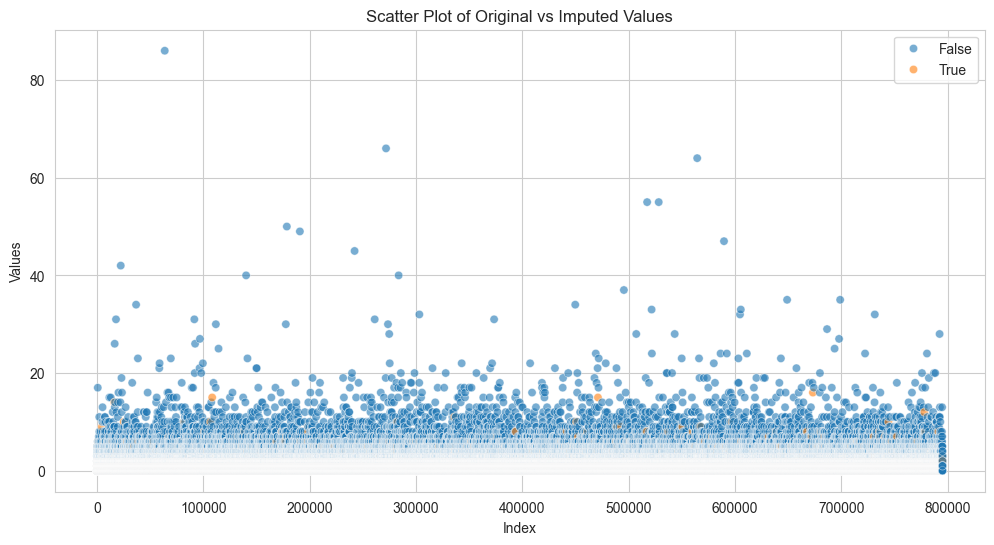

In [80]:
# Assuming you have a DataFrame named 'pandas_df' with original and imputed columns
pandas_df = cleaned_data.select("f_n_user_ids_by_device_id_30d", "chargeback").toPandas()
original_values = pandas_df["f_n_user_ids_by_device_id_30d"]
# imputed_values = pandas_df["f_chargeback_rate_by_geohash_5_30d_imputed"]

# Create a scatter plot
plt.figure(figsize=(12, 6))
sns.scatterplot(data=pandas_df, x=pandas_df.index, y="f_n_user_ids_by_device_id_30d", hue="chargeback", alpha=0.6)
# plt.scatter(range(len(imputed_values)), imputed_values, label='Imputed Values', alpha=0.6, color='red', marker='x')

# Set plot labels and title
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Scatter Plot of the Original')
plt.legend()
plt.show()

In [93]:
cleaned_data = impute_median(
    cleaned_data, 
    ["f_n_user_ids_by_device_id_30d"]
)

In [94]:
summary_stats = cleaned_data.selectExpr(
    "percentile_approx(f_n_user_ids_by_device_id_30d, 0.5) as median_original",
    "percentile_approx(f_n_user_ids_by_device_id_30d_imputed, 0.5) as median_imputed",
    "mean(f_n_user_ids_by_device_id_30d) as mean_original",
    "mean(f_n_user_ids_by_device_id_30d_imputed) as mean_imputed",
    "stddev(f_n_user_ids_by_device_id_30d) as stddev_original",
    "stddev(f_n_user_ids_by_device_id_30d_imputed) as stddev_imputed",
    "max(f_n_user_ids_by_device_id_30d) as max_original",
    "max(f_n_user_ids_by_device_id_30d_imputed) as max_imputed",
    "min(f_n_user_ids_by_device_id_30d) as min_original",
    "min(f_n_user_ids_by_device_id_30d_imputed) as min_imputed",
).show()

+---------------+--------------+------------------+------------------+-----------------+------------------+------------+-----------+------------+-----------+
|median_original|median_imputed|     mean_original|      mean_imputed|  stddev_original|    stddev_imputed|max_original|max_imputed|min_original|min_imputed|
+---------------+--------------+------------------+------------------+-----------------+------------------+------------+-----------+------------+-----------+
|              1|             1|1.0694937805557274|1.0564991365007967|1.045848200895315|0.9433996943524943|          86|         86|           0|          0|
+---------------+--------------+------------------+------------------+-----------------+------------------+------------+-----------+------------+-----------+



In [96]:
from scipy.stats import energy_distance

# Assuming original_values and imputed_values are your samples from the original and imputed distributions
pandas_df = cleaned_data.select("f_n_user_ids_by_device_id_30d", "f_n_user_ids_by_device_id_30d_imputed").toPandas()
original_values = pandas_df["f_n_user_ids_by_device_id_30d"].dropna()
imputed_values = pandas_df["f_n_user_ids_by_device_id_30d_imputed"]

# Calculate the energy distance
energy_dist = energy_distance(original_values, imputed_values)
print(f"Energy Distance: {energy_dist}")

Energy Distance: 0.06161956398719273


### Total number of fraudulent events associated with the device

In [97]:
missing_analysis(cleaned_data, "f_total_fraud_events", "chargeback")
stats = calculate_stats(cleaned_data, "f_total_fraud_events", "chargeback")
stats.show()

Missing value percentage grouped by chargeback:


,chargeback,missing_percentage
0,True,0.394161
1,False,0.537092


+----------+------+-----------------+------------------+---+---+------+---+----+----+
|chargeback| count|             mean|            stddev|min|25%|median|75%| 99%| max|
+----------+------+-----------------+------------------+---+---+------+---+----+----+
|      true| 10956|97.98722161372764|236.05988421916388|  0|  0|    14| 85|1201|2936|
|     false|359650|54.03470040316975|178.05099270914587|  0|  0|     2| 31| 835|6275|
+----------+------+-----------------+------------------+---+---+------+---+----+----+



In [98]:
missing_analysis(cleaned_data, "f_total_fraud_events", "provider")
stats = calculate_stats(cleaned_data, "f_total_fraud_events", "provider")
stats.show()

Missing value percentage grouped by provider:


,provider,missing_percentage
0,YOU,0.520883
1,EXTERNAL_2,0.513401
2,EXTERNAL_1,0.542212


+----------+------+------------------+------------------+---+---+------+---+---+----+
|  provider| count|              mean|            stddev|min|25%|median|75%|99%| max|
+----------+------+------------------+------------------+---+---+------+---+---+----+
|       YOU| 33634| 38.38478920140334|122.91233065446549|  0|  0|     1| 24|558|3560|
|EXTERNAL_2| 87107|57.633554134570126|184.00633784115973|  0|  0|     3| 33|894|4706|
|EXTERNAL_1|249865|  56.8139115122166| 185.1406662563432|  0|  0|     3| 33|865|6275|
+----------+------+------------------+------------------+---+---+------+---+---+----+



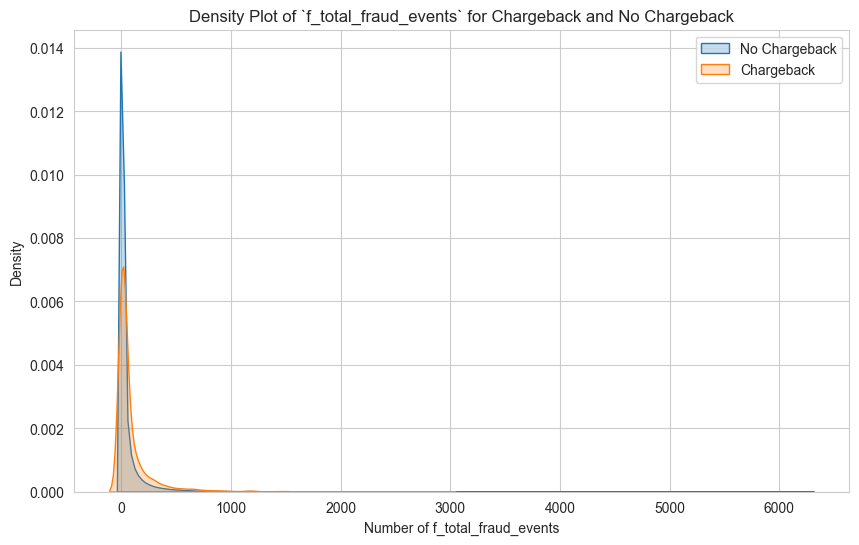

In [99]:
plot_feature_distribution(cleaned_data, "f_total_fraud_events")

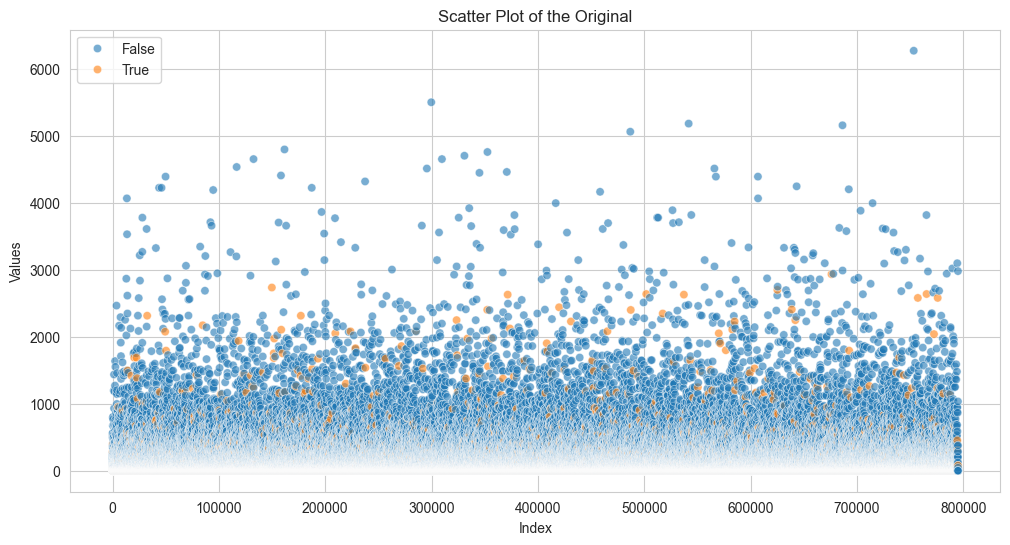

In [100]:
# Assuming you have a DataFrame named 'pandas_df' with original and imputed columns
pandas_df = cleaned_data.select("f_total_fraud_events", "chargeback").toPandas()
original_values = pandas_df["f_total_fraud_events"]

# Create a scatter plot
plt.figure(figsize=(12, 6))
sns.scatterplot(data=pandas_df, x=pandas_df.index, y="f_total_fraud_events", hue="chargeback", alpha=0.6)

# Set plot labels and title
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Scatter Plot of the Original')
plt.legend()
plt.show()

## Fraud events

In [51]:
cleaned_data = cleaned_data.withColumn("is_total_fraud_events_null", F.col("f_total_fraud_events").isNull().cast("int"))
cleaned_data = cleaned_data.withColumn("is_total_fraud_installations_null", F.col("f_total_fraud_installations").isNull().cast("int"))

In [55]:
cleaned_data.filter(F.col("chargeback") == "true").groupby("is_total_fraud_events_null").count().show()

+--------------------------+-----+
|is_total_fraud_events_null|count|
+--------------------------+-----+
|                         1| 7128|
|                         0|10956|
+--------------------------+-----+



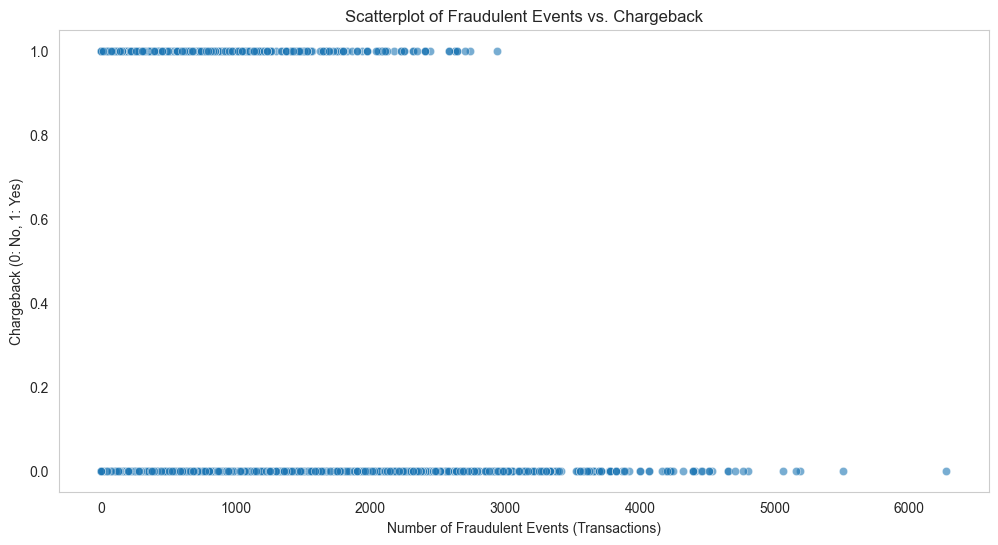

In [57]:
data_to_plot = cleaned_data.select("f_total_fraud_events", "chargeback").toPandas()

# Convert the 'chargeback' column to a numeric format if needed
data_to_plot['chargeback'] = data_to_plot['chargeback'].astype(int)

# Plot the scatterplot
plt.figure(figsize=(12, 6))
sns.scatterplot(x='f_total_fraud_events', y='chargeback', data=data_to_plot, alpha=0.6)
plt.title('Scatterplot of Fraudulent Events vs. Chargeback')
plt.xlabel('Number of Fraudulent Events (Transactions)')
plt.ylabel('Chargeback (0: No, 1: Yes)')
plt.grid()
plt.show()

/tmp/ipykernel_99038/2009581571.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(
/tmp/ipykernel_99038/2009581571.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(


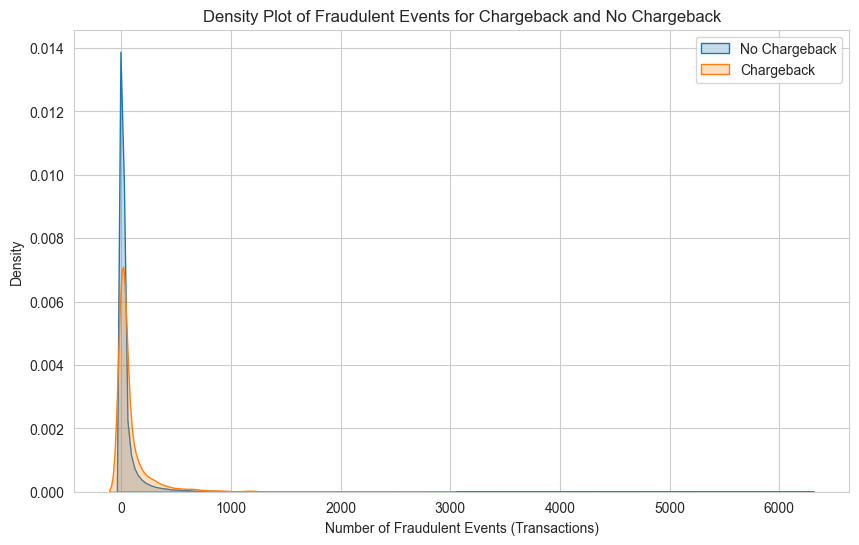

In [61]:
plt.figure(figsize=(10, 6))
sns.kdeplot(
    data=data_to_plot[data_to_plot['chargeback'] == 0]['f_total_fraud_events'], 
    label='No Chargeback', 
    shade=True
)
sns.kdeplot(
    data=data_to_plot[data_to_plot['chargeback'] == 1]['f_total_fraud_events'], 
    label='Chargeback', 
    shade=True
)
plt.title('Density Plot of Fraudulent Events for Chargeback and No Chargeback')
plt.xlabel('Number of Fraudulent Events (Transactions)')
plt.ylabel('Density')
plt.legend()
plt.show()

/tmp/ipykernel_99038/4160226098.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(
/tmp/ipykernel_99038/4160226098.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(


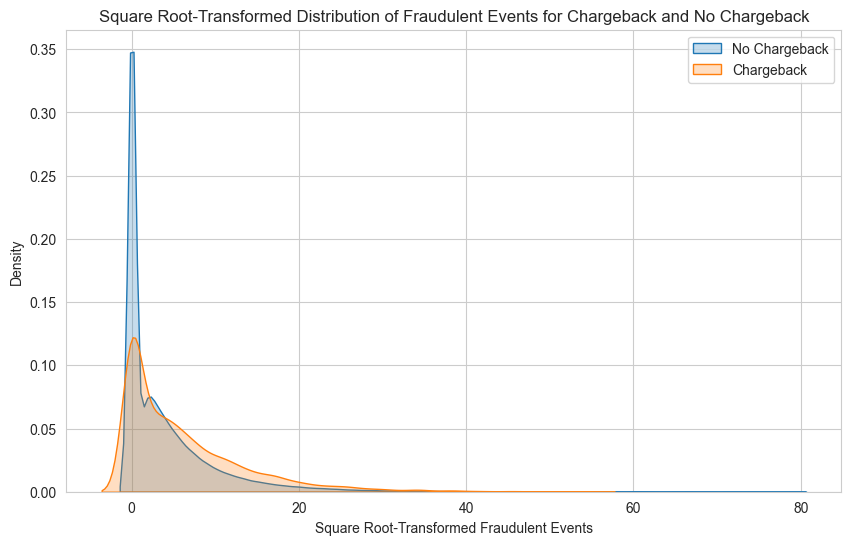

In [76]:
data_to_plot['sqrt_f_total_fraud_events'] = np.sqrt(data_to_plot['f_total_fraud_events'])

plt.figure(figsize=(10, 6))
sns.kdeplot(
    data=data_to_plot[data_to_plot['chargeback'] == 0]['sqrt_f_total_fraud_events'], 
    label='No Chargeback', 
    shade=True
)
sns.kdeplot(
    data=data_to_plot[data_to_plot['chargeback'] == 1]['sqrt_f_total_fraud_events'], 
    label='Chargeback', 
    shade=True
)
plt.title('Square Root-Transformed Distribution of Fraudulent Events for Chargeback and No Chargeback')
plt.xlabel('Square Root-Transformed Fraudulent Events')
plt.ylabel('Density')
plt.legend()
plt.show()

/tmp/ipykernel_99038/2788829027.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(
/tmp/ipykernel_99038/2788829027.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(


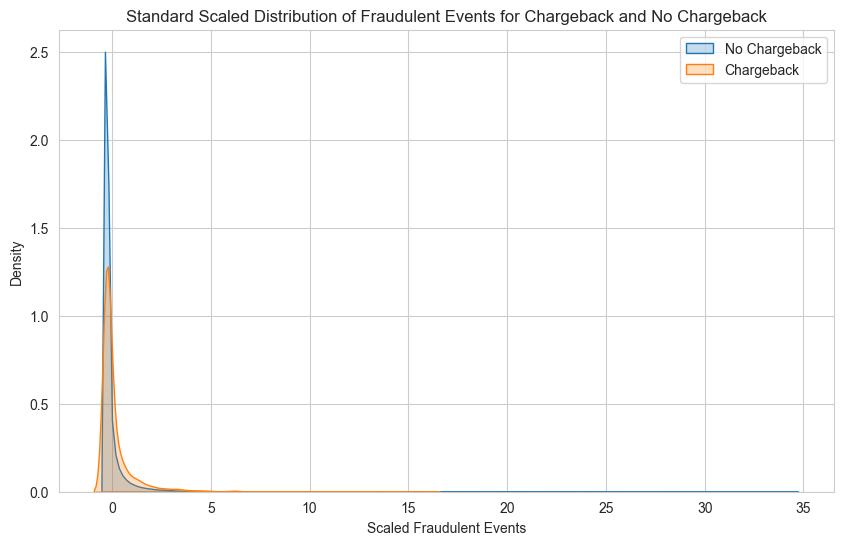

In [75]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data_to_plot['scaled_f_total_fraud_events'] = scaler.fit_transform(data_to_plot[['f_total_fraud_events']])

plt.figure(figsize=(10, 6))
sns.kdeplot(
    data=data_to_plot[data_to_plot['chargeback'] == 0]['scaled_f_total_fraud_events'], 
    label='No Chargeback', 
    shade=True
)
sns.kdeplot(
    data=data_to_plot[data_to_plot['chargeback'] == 1]['scaled_f_total_fraud_events'], 
    label='Chargeback', 
    shade=True
)
plt.title('Standard Scaled Distribution of Fraudulent Events for Chargeback and No Chargeback')
plt.xlabel('Scaled Fraudulent Events')
plt.ylabel('Density')
plt.legend()
plt.show()

## Total amount

In [78]:
data_to_plot = cleaned_data.select("total_amount", "chargeback").toPandas()
data_to_plot['chargeback'] = data_to_plot['chargeback'].astype(int)

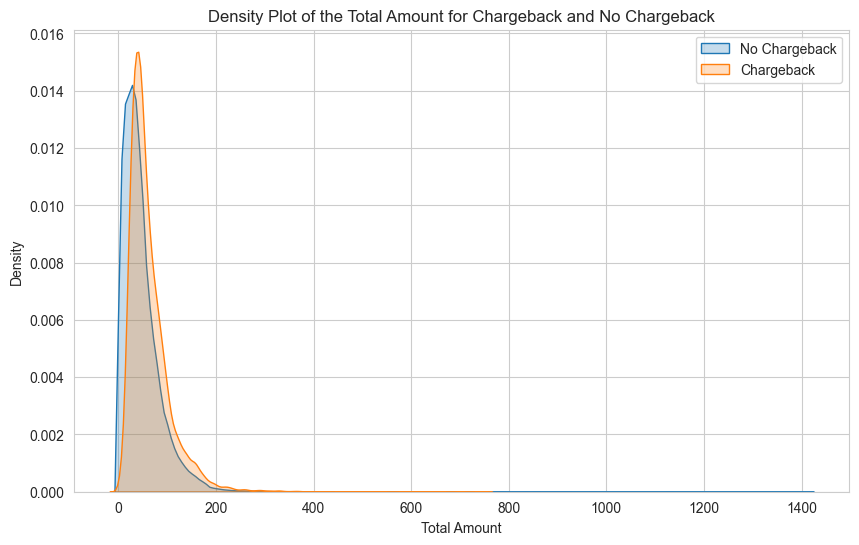

In [80]:
plt.figure(figsize=(10, 6))
sns.kdeplot(
    data=data_to_plot[data_to_plot['chargeback'] == 0]['total_amount'], 
    label='No Chargeback', 
    fill=True
)
sns.kdeplot(
    data=data_to_plot[data_to_plot['chargeback'] == 1]['total_amount'], 
    label='Chargeback', 
    fill=True
)
plt.title('Density Plot of the Total Amount for Chargeback and No Chargeback')
plt.xlabel('Total Amount')
plt.ylabel('Density')
plt.legend()
plt.show()

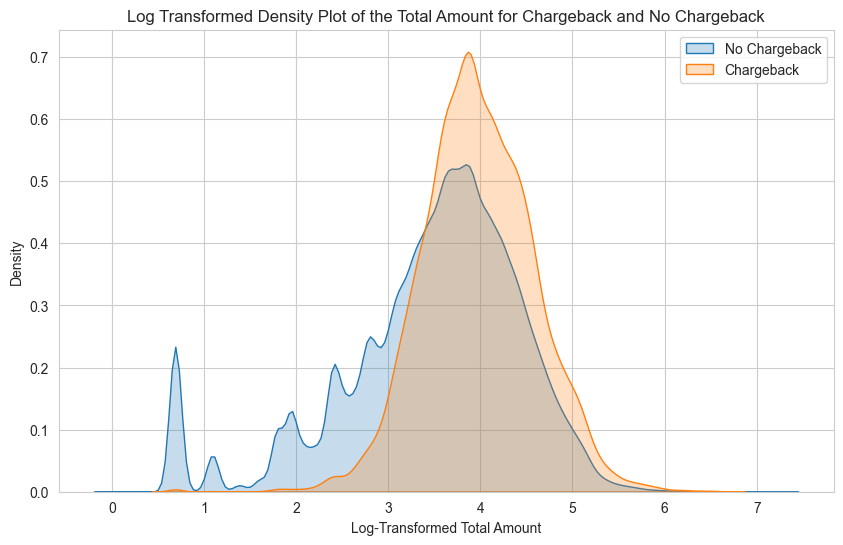

In [82]:
data_to_plot['log_total_amount'] = np.log1p(data_to_plot['total_amount'])

plt.figure(figsize=(10, 6))
sns.kdeplot(
    data=data_to_plot[data_to_plot['chargeback'] == 0]['log_total_amount'], 
    label='No Chargeback', 
    fill=True
)
sns.kdeplot(
    data=data_to_plot[data_to_plot['chargeback'] == 1]['log_total_amount'], 
    label='Chargeback', 
    fill=True
)
plt.title('Log Transformed Density Plot of the Total Amount for Chargeback and No Chargeback')
plt.xlabel('Log-Transformed Total Amount')
plt.ylabel('Density')
plt.legend()
plt.show()

In [16]:
window_spec = Window.partitionBy("installation_id").orderBy(F.col("timestamp").cast("long")).rangeBetween(-3 * 86400, 0)
cleaned_data = cleaned_data.withColumn("f_sum_values_by_ilm_id_3d_reconstructed", F.sum("total_amount").over(window_spec))

In [17]:
cleaned_data.select("installation_id", "dt", "f_sum_values_by_ilm_id_3d_reconstructed", "f_sum_values_by_ilm_id_3d").show(10)

+--------------------+----------+---------------------------------------+-------------------------+
|     installation_id|        dt|f_sum_values_by_ilm_id_3d_reconstructed|f_sum_values_by_ilm_id_3d|
+--------------------+----------+---------------------------------------+-------------------------+
|000391784ca200511...|2023-07-20|                     40.880001068115234|                     NULL|
|00043dbcb0a75b693...|2023-09-04|                                   15.0|                     NULL|
|00045cba5195eb878...|2023-09-15|                                   66.0|                     NULL|
|0004bc3226fcebbd9...|2023-07-16|                     16.979999542236328|                     NULL|
|0004c0a5727016713...|2023-07-28|                                   26.5|                     NULL|
|00056d7d8443facc2...|2023-06-22|                     34.880001068115234|                     NULL|
|00059fb5461c7d483...|2023-07-13|                     30.989999771118164|                     NULL|


In [18]:
cleaned_data = cleaned_data.withColumn(
    "f_sum_values_by_ilm_id_3d_imputed",
    F.when(
        F.col("f_sum_values_by_ilm_id_3d").isNull(),
        F.col("f_sum_values_by_ilm_id_3d_reconstructed")
    ).otherwise(F.col("f_sum_values_by_ilm_id_3d"))
)

In [19]:
cleaned_data.select("f_sum_values_by_ilm_id_3d_reconstructed", "f_sum_values_by_ilm_id_3d", "f_sum_values_by_ilm_id_3d_imputed").describe().show()

+-------+---------------------------------------+-------------------------+---------------------------------+
|summary|f_sum_values_by_ilm_id_3d_reconstructed|f_sum_values_by_ilm_id_3d|f_sum_values_by_ilm_id_3d_imputed|
+-------+---------------------------------------+-------------------------+---------------------------------+
|  count|                                 795021|                   229425|                           795021|
|   mean|                      51.60813587139392|        69.56182126934081|               52.232038083809044|
| stddev|                     50.671130186673906|       307.84647096233306|                169.1459194137033|
|    min|                                    0.0|                      0.0|                              0.0|
|    max|                      1583.469970703125|                 40585.77|                   40585.76953125|
+-------+---------------------------------------+-------------------------+---------------------------------+



In [20]:
window_spec = Window.partitionBy("device_id").orderBy(F.col("timestamp").cast("long")).rangeBetween(-3 * 86400, 0)
cleaned_data = cleaned_data.withColumn("f_sum_values_by_device_id_3d_reconstructed", F.sum("total_amount").over(window_spec))

cleaned_data = cleaned_data.withColumn(
    "f_sum_values_by_device_id_3d_imputed",
    F.when(
        F.col("f_sum_values_by_device_id_3d").isNull(),
        F.col("f_sum_values_by_device_id_3d_reconstructed")
    ).otherwise(F.col("f_sum_values_by_device_id_3d"))
)

In [21]:
cleaned_data.select("f_sum_values_by_device_id_3d_reconstructed", "f_sum_values_by_device_id_3d", "f_sum_values_by_device_id_3d_imputed").describe().show()

+-------+------------------------------------------+----------------------------+------------------------------------+
|summary|f_sum_values_by_device_id_3d_reconstructed|f_sum_values_by_device_id_3d|f_sum_values_by_device_id_3d_imputed|
+-------+------------------------------------------+----------------------------+------------------------------------+
|  count|                                    795021|                      275792|                              795021|
|   mean|                         51.68556245501445|          60.092402769047666|                   50.61282619926226|
| stddev|                         50.81306401469958|           291.2920830284467|                   174.7261774461836|
|    min|                                       0.0|                         0.0|                                 0.0|
|    max|                         1583.469970703125|                    40585.77|                      40585.76953125|
+-------+---------------------------------------

In [22]:
# Calculate the total number of installations per device
f_total_installations = cleaned_data.groupBy("device_id").agg(
    F.countDistinct("installation_id").alias("f_total_installations_reconstructed")
)

cleaned_data = cleaned_data.join(f_total_installations, on="device_id", how="left")

cleaned_data.select("f_total_installations", "f_total_installations_reconstructed").describe().show()

+-------+---------------------+-----------------------------------+
|summary|f_total_installations|f_total_installations_reconstructed|
+-------+---------------------+-----------------------------------+
|  count|               370606|                             795021|
|   mean|   2850.2318553935984|                 1.0223490951811336|
| stddev|    6921.032036619691|                0.19888402543181444|
|    min|                    1|                                  1|
|    max|               228883|                                 10|
+-------+---------------------+-----------------------------------+



In [23]:
cleaned_data = cleaned_data.withColumn(
    "f_total_installations_imputed",
    F.when(
        F.col("f_total_installations").isNull(),
        F.col("f_total_installations_reconstructed")
    ).otherwise(F.col("f_total_installations"))
)

In [24]:
# Define window to partition by provider
window = Window.partitionBy("provider")

# Impute missing installations by provider
cleaned_data = cleaned_data.withColumn(
    "f_total_installations_imputed_by_provider",
    F.when(F.col("f_total_installations").isNull(), 
           F.avg("f_total_installations").over(window)).otherwise(F.col("f_total_installations"))
)

In [25]:
# Impute missing events by provider
cleaned_data = cleaned_data.withColumn(
    "f_total_events_imputed_by_provider",
    F.when(F.col("f_total_events").isNull(), 
           F.avg("f_total_events").over(window)).otherwise(F.col("f_total_events"))
)

In [26]:
cleaned_data.select("f_total_installations", "f_total_installations_imputed", "f_total_installations_imputed_by_provider").describe().show()

+-------+---------------------+-----------------------------+-----------------------------------------+
|summary|f_total_installations|f_total_installations_imputed|f_total_installations_imputed_by_provider|
+-------+---------------------+-----------------------------+-----------------------------------------+
|  count|               370606|                       795021|                                   795021|
|   mean|   2850.2318553935984|            1329.205121625718|                       2850.1685652407728|
| stddev|    6921.032036619685|            4934.521124995128|                        4725.740819875029|
|    min|                    1|                            1|                                      1.0|
|    max|               228883|                       228883|                                 228883.0|
+-------+---------------------+-----------------------------+-----------------------------------------+



### Group-Based Imputation (Features with over 50% Missing)

These features have high missingness and need to be imputed based on their provider group:

- f_sum_values_by_ilm_id_30d (71%)
- f_sum_values_by_ilm_id_3d (71%)
- f_sum_values_by_device_id_30d (65%)
- f_sum_values_by_device_id_3d (65%)
- f_total_events, f_total_installations, f_total_fraud_installations, f_total_fraud_events, f_avg_fraud_installations, f_avg_fraud_events (53%)

In [19]:
# Define window to partition by provider
window = Window.partitionBy("provider")

# Impute missing fraud events by provider
cleaned_data = cleaned_data.withColumn(
    "f_total_fraud_events_imputed",
    F.when(F.col("f_total_fraud_events").isNull(), 
           F.avg("f_total_fraud_events").over(window)).otherwise(F.col("f_total_fraud_events"))
)

# Impute missing fraud events by provider
cleaned_data = cleaned_data.withColumn(
    "f_total_fraud_installations_imputed",
    F.when(F.col("f_total_fraud_installations").isNull(), 
           F.avg("f_total_fraud_installations").over(window)).otherwise(F.col("f_total_fraud_installations"))
)

# Impute missing sum values by ilm id by provider
cleaned_data = cleaned_data.withColumn(
    "f_sum_values_by_ilm_id_30d_imputed",
    F.when(F.col("f_sum_values_by_ilm_id_30d").isNull(), 
           F.avg("f_sum_values_by_ilm_id_30d").over(window)).otherwise(F.col("f_sum_values_by_ilm_id_30d"))
)

# Impute missing sum values by ilm id by provider
cleaned_data = cleaned_data.withColumn(
    "f_sum_values_by_device_id_30d_imputed",
    F.when(F.col("f_sum_values_by_device_id_30d").isNull(), 
           F.avg("f_sum_values_by_device_id_30d").over(window)).otherwise(F.col("f_sum_values_by_device_id_30d"))
)

### Median/Mean Imputation (Features with 10-50% Missing)

In [20]:
# Median imputation for f_boot_count
median_boot_count = cleaned_data.approxQuantile("f_boot_count", [0.5], 0.01)[0]
cleaned_data = cleaned_data.fillna({"f_boot_count": median_boot_count})

# Median imputation for f_wallpaper_id
median_wallpaper_id = cleaned_data.approxQuantile("f_wallpaper_id", [0.5], 0.01)[0]
cleaned_data = cleaned_data.fillna({"f_wallpaper_id": median_wallpaper_id})

# Median imputation for chargeback rates by geohash levels
median_chargeback_geohash_5 = cleaned_data.approxQuantile("f_chargeback_rate_by_geohash_5_30d", [0.5], 0.01)[0]
median_chargeback_geohash_6 = cleaned_data.approxQuantile("f_chargeback_rate_by_geohash_6_30d", [0.5], 0.01)[0]
median_chargeback_geohash_7 = cleaned_data.approxQuantile("f_chargeback_rate_by_geohash_7_30d", [0.5], 0.01)[0]

cleaned_data = cleaned_data.fillna({
    "f_chargeback_rate_by_geohash_5_30d": median_chargeback_geohash_5,
    "f_chargeback_rate_by_geohash_6_30d": median_chargeback_geohash_6,
    "f_chargeback_rate_by_geohash_7_30d": median_chargeback_geohash_7
})

# Median imputation for device-related features
median_n_user_ids = cleaned_data.approxQuantile("f_n_user_ids_by_device_id_30d", [0.5], 0.01)[0]
median_n_installations = cleaned_data.approxQuantile("f_n_installations_by_device_id_30d", [0.5], 0.01)[0]

cleaned_data = cleaned_data.fillna({
    "f_n_user_ids_by_device_id_30d": median_n_user_ids,
    "f_n_installations_by_device_id_30d": median_n_installations
})

# Feature Engineering

In [14]:
def impute_median(train_df, test_df, features):
    imputer = Imputer(
        inputCols=features, 
        outputCols=[f"{feat}_imputed" for feat in features],
        strategy="median"
    )

    model = imputer.fit(train_df)
    train_df = model.transform(train_df)
    test_df = model.transform(test_df)
    return train_df, test_df

In [15]:
data = raw_data.alias("data")
data = data.withColumn("chargeback", F.col("chargeback").cast(StringType()))
indexer_chargeback = StringIndexer(inputCol="chargeback", outputCol="label")
data = indexer_chargeback.fit(data).transform(data)

train_data, test_data = stratified_split(data, [0.8, 0.2], "label")

In [16]:
train_dist = calculate_class_distribution(train_data, label_col="label")
test_dist = calculate_class_distribution(test_data, label_col="label")

print("Training Data Distribution:")
train_dist.show()

print("Test Data Distribution:")
test_dist.show()

24/10/12 20:05:18 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Training Data Distribution:


+-----+------+-----------------+
|label| count|       percentage|
+-----+------+-----------------+
|  1.0| 14442|2.269919557898509|
|  0.0|621792|97.73008044210148|
+-----+------+-----------------+

Test Data Distribution:


+-----+------+-----------------+
|label| count|       percentage|
+-----+------+-----------------+
|  1.0|  3642|2.293638648000151|
|  0.0|155145|97.70636135199985|
+-----+------+-----------------+



The proportions are close, so that the distribution was preserved during the splitting process.

In [17]:
def check_multicollinearity(df, feature_cols):
    corr_data = df.select(feature_cols)
    # Convert the selected features into an RDD format (Resilient Distributed Dataset)
    features = corr_data.rdd.map(lambda row: row[0:])
    corr_mat = Statistics.corr(features, method="spearman")

    corr_matrix_df = pd.DataFrame(data=corr_mat, columns=feature_cols, index=feature_cols)
    return corr_matrix_df

## Time-based features

In [18]:
def create_time_based_features(df, entity_col, time_col='timestamp', amount_col='total_amount'):
    """
    Create features based on the past 1 day, 1 week, 1 month, and 3 months 
    for each entity (device_id, installation_id, account_id, etc.)

    Parameters:
    - df: the PySpark DataFrame.
    - entity_col: the column based on which to calculate features (e.g., device_id, installation_id, etc.).
    - time_col: the column representing the timestamp of each transaction (default is 'timestamp').
    - amount_col: the column representing the amount of each transaction (default is 'total_amount').

    Returns:
    - df: PySpark DataFrame with new time-based features.
    """
    
    # Define window specs for time intervals (in seconds)
    window_1d = Window.partitionBy(entity_col).orderBy(F.col(time_col).cast("long")).rangeBetween(-1 * 86400, 0)
    window_1w = Window.partitionBy(entity_col).orderBy(F.col(time_col).cast("long")).rangeBetween(-7 * 86400, 0)
    window_1m = Window.partitionBy(entity_col).orderBy(F.col(time_col).cast("long")).rangeBetween(-30 * 86400, 0)
    window_3m = Window.partitionBy(entity_col).orderBy(F.col(time_col).cast("long")).rangeBetween(-90 * 86400, 0)

    # Create features for 1 day
    df = df.withColumn(f'amount_sum_by_{entity_col}_1d', F.sum(amount_col).over(window_1d))
    df = df.withColumn(f'amount_count_by_{entity_col}_1d', F.count(amount_col).over(window_1d))
    df = df.withColumn(f'amount_avg_by_{entity_col}_1d', F.avg(amount_col).over(window_1d))

    # Create features for 1 week
    df = df.withColumn(f'amount_sum_by_{entity_col}_1w', F.sum(amount_col).over(window_1w))
    df = df.withColumn(f'amount_count_by_{entity_col}_1w', F.count(amount_col).over(window_1w))
    df = df.withColumn(f'amount_avg_by_{entity_col}_1w', F.avg(amount_col).over(window_1w))

    # Create features for 1 month
    df = df.withColumn(f'amount_sum_by_{entity_col}_1m', F.sum(amount_col).over(window_1m))
    df = df.withColumn(f'amount_count_by_{entity_col}_1m', F.count(amount_col).over(window_1m))
    df = df.withColumn(f'amount_avg_by_{entity_col}_1m', F.avg(amount_col).over(window_1m))

    # Create features for 3 months
    df = df.withColumn(f'amount_sum_by_{entity_col}_3m', F.sum(amount_col).over(window_3m))
    df = df.withColumn(f'amount_count_by_{entity_col}_3m', F.count(amount_col).over(window_3m))
    df = df.withColumn(f'amount_avg_by_{entity_col}_3m', F.avg(amount_col).over(window_3m))

    # Extract specific time units (day of week, month, hour)
    df = df.withColumn('day_of_week', F.dayofweek(time_col))
    df = df.withColumn('month', F.month(time_col))
    df = df.withColumn('hour_of_day', F.hour(time_col))

    # Create windows to aggregate by day of week, month, and hour
    window_day_of_week = Window.partitionBy(entity_col, 'day_of_week')
    window_month = Window.partitionBy(entity_col, 'month')
    window_hour_of_day = Window.partitionBy(entity_col, 'hour_of_day')

    # Features based on day of week
    # Number of transactions for a specific entity (e.g., device_id, installation_id, etc.) on a particular day of the week.
    df = df.withColumn(f'{entity_col}_amount_count_day_of_week', F.count(amount_col).over(window_day_of_week))
    # Total transaction amount for a specific entity on a particular day of the week.
    df = df.withColumn(f'{entity_col}_amount_sum_day_of_week', F.sum(amount_col).over(window_day_of_week))

    # Features based on month
    # Number of transactions for a specific entity in a specific month.
    df = df.withColumn(f'{entity_col}_amount_count_month', F.count(amount_col).over(window_month))
    # Total transaction amount for a specific entity in a specific month.
    df = df.withColumn(f'{entity_col}_amount_sum_month', F.sum(amount_col).over(window_month))

    # Features based on hour of day
    # Number of transactions for a specific entity during a specific hour of the day.
    df = df.withColumn(f'{entity_col}_amount_count_hour_of_day', F.count(amount_col).over(window_hour_of_day))
    # Total transaction amount for a specific entity during a specific hour of the day.
    df = df.withColumn(f'{entity_col}_amount_sum_hour_of_day', F.sum(amount_col).over(window_hour_of_day))

    return df

In [19]:
train_data = create_time_based_features(train_data, entity_col="device_id", time_col='timestamp', amount_col='total_amount')
train_data = create_time_based_features(train_data, entity_col="installation_id", time_col='timestamp', amount_col='total_amount')
train_data = create_time_based_features(train_data, entity_col="account_id", time_col='timestamp', amount_col='total_amount')

test_data = create_time_based_features(test_data, entity_col="device_id", time_col='timestamp', amount_col='total_amount')
test_data = create_time_based_features(test_data, entity_col="installation_id", time_col='timestamp', amount_col='total_amount')
test_data = create_time_based_features(test_data, entity_col="account_id", time_col='timestamp', amount_col='total_amount')

### Check multicollinearity

In [56]:
check_multicollinearity(
    train_data, 
    [
        "amount_sum_by_device_id_1d",
        "amount_sum_by_device_id_1w", 
        "amount_sum_by_device_id_1m",
        "amount_sum_by_device_id_3m",
        "amount_avg_by_device_id_1d",
        "amount_avg_by_device_id_1w", 
        "amount_avg_by_device_id_1m",
        "amount_avg_by_device_id_3m",
        "amount_count_by_device_id_1d",
        "amount_count_by_device_id_1w", 
        "amount_count_by_device_id_1m",
        "amount_count_by_device_id_3m",
        "device_id_amount_count_day_of_week",
        "device_id_amount_sum_day_of_week",
        "device_id_amount_count_month",
        "device_id_amount_sum_month",
        "device_id_amount_count_hour_of_day",
        "device_id_amount_sum_hour_of_day",
        "label"
    ]
)

24/10/12 15:00:50 WARN Executor: Managed memory leak detected; size = 36719474 bytes, task 0.0 in stage 809.0 (TID 6032)
24/10/12 15:00:54 WARN Executor: Managed memory leak detected; size = 36719474 bytes, task 0.0 in stage 818.0 (TID 6053)


,amount_sum_by_device_id_1d,amount_sum_by_device_id_1w,amount_sum_by_device_id_1m,amount_sum_by_device_id_3m,amount_avg_by_device_id_1d,amount_avg_by_device_id_1w,amount_avg_by_device_id_1m,amount_avg_by_device_id_3m,amount_count_by_device_id_1d,amount_count_by_device_id_1w,amount_count_by_device_id_1m,amount_count_by_device_id_3m,device_id_amount_count_day_of_week,device_id_amount_sum_day_of_week,device_id_amount_count_month,device_id_amount_sum_month,device_id_amount_count_hour_of_day,device_id_amount_sum_hour_of_day,label
amount_sum_by_device_id_1d,1.000000,0.982307,0.971764,0.967069,0.982951,0.980663,0.978871,0.977887,0.209561,0.200562,0.198372,0.195402,0.147546,0.970571,0.179674,0.948891,0.110334,0.970733,0.102002
amount_sum_by_device_id_1w,0.982307,1.000000,0.991258,0.986881,0.963216,0.967859,0.966634,0.965801,0.216733,0.307691,0.294605,0.287529,0.184852,0.965284,0.256999,0.968181,0.149737,0.963688,0.114002
amount_sum_by_device_id_1m,0.971764,0.991258,1.000000,0.996039,0.952343,0.956975,0.959237,0.958465,0.217058,0.313044,0.346781,0.337587,0.205835,0.961949,0.286350,0.971344,0.167117,0.958199,0.118571
amount_sum_by_device_id_3m,0.967069,0.986881,0.996039,1.000000,0.947593,0.952220,0.954467,0.955588,0.216796,0.313545,0.348391,0.359763,0.212192,0.959486,0.290279,0.968672,0.172485,0.955119,0.119041
amount_avg_by_device_id_1d,0.982951,0.963216,0.952343,0.947593,1.000000,0.997028,0.994935,0.993849,0.041478,0.073103,0.085101,0.087324,0.048529,0.958173,0.086739,0.928457,0.031286,0.967737,0.078132
amount_avg_by_device_id_1w,0.980663,0.967859,0.956975,0.952220,0.997028,1.000000,0.997885,0.996795,0.043629,0.082987,0.094002,0.095859,0.052986,0.957990,0.094034,0.932766,0.035011,0.967011,0.079200
amount_avg_by_device_id_1m,0.978871,0.966634,0.959237,0.954467,0.994935,0.997885,1.000000,0.998910,0.044343,0.084452,0.096619,0.098384,0.054731,0.957683,0.096145,0.933702,0.036112,0.966098,0.079386
amount_avg_by_device_id_3m,0.977887,0.965801,0.958465,0.955588,0.993849,0.996795,0.998910,1.000000,0.044571,0.084800,0.096867,0.099345,0.055132,0.957180,0.096592,0.933171,0.036455,0.965445,0.079435
amount_count_by_device_id_1d,0.209561,0.216733,0.217058,0.216796,0.041478,0.043629,0.044343,0.044571,1.000000,0.763291,0.680451,0.649717,0.589870,0.181768,0.559801,0.219225,0.471523,0.134677,0.145512
amount_count_by_device_id_1w,0.200562,0.307691,0.313044,0.313545,0.073103,0.082987,0.084452,0.084800,0.763291,1.000000,0.895634,0.856341,0.576052,0.213258,0.728448,0.312495,0.499309,0.175314,0.160409


In [57]:
check_multicollinearity(
    train_data, 
    [
        "amount_sum_by_account_id_1d",
        "amount_sum_by_account_id_1w", 
        "amount_sum_by_account_id_1m",
        "amount_sum_by_account_id_3m",
        "amount_avg_by_account_id_1d",
        "amount_avg_by_account_id_1w", 
        "amount_avg_by_account_id_1m",
        "amount_avg_by_account_id_3m",
        "amount_count_by_account_id_1d",
        "amount_count_by_account_id_1w", 
        "amount_count_by_account_id_1m",
        "amount_count_by_account_id_3m",
        "account_id_amount_count_day_of_week",
        "account_id_amount_sum_day_of_week",
        "account_id_amount_count_month",
        "account_id_amount_sum_month",
        "account_id_amount_count_hour_of_day",
        "account_id_amount_sum_hour_of_day",
        "label"
    ]
)

24/10/12 15:02:19 WARN Executor: Managed memory leak detected; size = 36702952 bytes, task 0.0 in stage 833.0 (TID 6173)
24/10/12 15:02:23 WARN Executor: Managed memory leak detected; size = 36702952 bytes, task 0.0 in stage 842.0 (TID 6194)


,amount_sum_by_account_id_1d,amount_sum_by_account_id_1w,amount_sum_by_account_id_1m,amount_sum_by_account_id_3m,amount_avg_by_account_id_1d,amount_avg_by_account_id_1w,amount_avg_by_account_id_1m,amount_avg_by_account_id_3m,amount_count_by_account_id_1d,amount_count_by_account_id_1w,amount_count_by_account_id_1m,amount_count_by_account_id_3m,account_id_amount_count_day_of_week,account_id_amount_sum_day_of_week,account_id_amount_count_month,account_id_amount_sum_month,account_id_amount_count_hour_of_day,account_id_amount_sum_hour_of_day,label
amount_sum_by_account_id_1d,1.000000,0.982953,0.973917,0.970672,0.983082,0.980919,0.979461,0.978816,0.211883,0.209527,0.217426,0.221233,0.158265,0.971856,0.199344,0.951252,0.121923,0.971869,0.101774
amount_sum_by_account_id_1w,0.982953,1.000000,0.992703,0.989716,0.964001,0.968447,0.967533,0.967019,0.219158,0.313922,0.312562,0.313171,0.195376,0.966860,0.275568,0.970012,0.161171,0.965203,0.113451
amount_sum_by_account_id_1m,0.973917,0.992703,1.000000,0.997378,0.954649,0.959078,0.960897,0.960430,0.219540,0.319256,0.357955,0.357161,0.214999,0.964418,0.302322,0.973268,0.176982,0.960664,0.117942
amount_sum_by_account_id_3m,0.970672,0.989716,0.997378,1.000000,0.951379,0.955800,0.957614,0.958184,0.219274,0.319643,0.359302,0.373210,0.219862,0.962814,0.305970,0.971815,0.180951,0.958590,0.118244
amount_avg_by_account_id_1d,0.983082,0.964001,0.954649,0.951379,1.000000,0.997162,0.995406,0.994679,0.044183,0.081223,0.101625,0.109587,0.057992,0.959471,0.104929,0.930979,0.041395,0.968777,0.078115
amount_avg_by_account_id_1w,0.980919,0.968447,0.959078,0.955800,0.997162,1.000000,0.998220,0.997494,0.046332,0.091041,0.110599,0.118278,0.062264,0.959286,0.112256,0.935127,0.045192,0.968137,0.079080
amount_avg_by_account_id_1m,0.979461,0.967533,0.960897,0.957614,0.995406,0.998220,1.000000,0.999274,0.047034,0.092476,0.112881,0.120510,0.063902,0.959154,0.114153,0.935995,0.046138,0.967419,0.079307
amount_avg_by_account_id_3m,0.978816,0.967019,0.960430,0.958184,0.994679,0.997494,0.999274,1.000000,0.047199,0.092730,0.113019,0.120705,0.064033,0.958806,0.114431,0.935721,0.046284,0.966984,0.079296
amount_count_by_account_id_1d,0.211883,0.219158,0.219540,0.219274,0.044183,0.046332,0.047034,0.047199,1.000000,0.770971,0.699169,0.675331,0.599947,0.184676,0.572314,0.221749,0.482900,0.137864,0.145554
amount_count_by_account_id_1w,0.209527,0.313922,0.319256,0.319643,0.081223,0.091041,0.092476,0.092730,0.770971,1.000000,0.910913,0.880848,0.589906,0.222068,0.738688,0.319275,0.512344,0.183987,0.161314


In [59]:
check_multicollinearity(
    train_data, 
    [
        "amount_sum_by_installation_id_1d",
        "amount_sum_by_installation_id_1w", 
        "amount_sum_by_installation_id_1m",
        "amount_sum_by_installation_id_3m",
        "amount_avg_by_installation_id_1d",
        "amount_avg_by_installation_id_1w", 
        "amount_avg_by_installation_id_1m",
        "amount_avg_by_installation_id_3m",
        "amount_count_by_installation_id_1d",
        "amount_count_by_installation_id_1w", 
        "amount_count_by_installation_id_1m",
        "amount_count_by_installation_id_3m",
        "installation_id_amount_count_day_of_week",
        "installation_id_amount_sum_day_of_week",
        "installation_id_amount_count_month",
        "installation_id_amount_sum_month",
        "installation_id_amount_count_hour_of_day",
        "installation_id_amount_sum_hour_of_day",
        "label"
    ]
)

24/10/12 15:08:56 WARN Executor: Managed memory leak detected; size = 36707706 bytes, task 0.0 in stage 857.0 (TID 6314)
24/10/12 15:09:00 WARN Executor: Managed memory leak detected; size = 36707706 bytes, task 0.0 in stage 866.0 (TID 6335)


,amount_sum_by_installation_id_1d,amount_sum_by_installation_id_1w,amount_sum_by_installation_id_1m,amount_sum_by_installation_id_3m,amount_avg_by_installation_id_1d,amount_avg_by_installation_id_1w,amount_avg_by_installation_id_1m,amount_avg_by_installation_id_3m,amount_count_by_installation_id_1d,amount_count_by_installation_id_1w,amount_count_by_installation_id_1m,amount_count_by_installation_id_3m,installation_id_amount_count_day_of_week,installation_id_amount_sum_day_of_week,installation_id_amount_count_month,installation_id_amount_sum_month,installation_id_amount_count_hour_of_day,installation_id_amount_sum_hour_of_day,label
amount_sum_by_installation_id_1d,1.000000,0.983077,0.973921,0.970428,0.983085,0.980919,0.979376,0.978644,0.208990,0.201973,0.202573,0.202064,0.148840,0.971989,0.183060,0.951018,0.111810,0.971820,0.101722
amount_sum_by_installation_id_1w,0.983077,1.000000,0.992491,0.989251,0.964185,0.968586,0.967549,0.966952,0.215986,0.305710,0.296864,0.293138,0.184336,0.966583,0.258316,0.969477,0.149897,0.964947,0.112849
amount_sum_by_installation_id_1m,0.973921,0.992491,1.000000,0.997126,0.954742,0.959139,0.961042,0.960504,0.216269,0.310690,0.343028,0.337843,0.203000,0.963692,0.284728,0.972438,0.165316,0.960153,0.116773
amount_sum_by_installation_id_3m,0.970428,0.989251,0.997126,1.000000,0.951210,0.955604,0.957498,0.958310,0.216042,0.311089,0.344446,0.354767,0.207919,0.961885,0.288004,0.970591,0.169599,0.957935,0.117121
amount_avg_by_installation_id_1d,0.983085,0.964185,0.954742,0.951210,1.000000,0.997185,0.995378,0.994549,0.041540,0.073927,0.087330,0.091035,0.048784,0.959748,0.089315,0.930848,0.031929,0.968878,0.078117
amount_avg_by_installation_id_1w,0.980919,0.968586,0.959139,0.955604,0.997185,1.000000,0.998171,0.997342,0.043596,0.083456,0.096020,0.099445,0.052995,0.959519,0.096395,0.934958,0.035557,0.968193,0.079063
amount_avg_by_installation_id_1m,0.979376,0.967549,0.961042,0.957498,0.995378,0.998171,1.000000,0.999172,0.044211,0.084768,0.098238,0.101608,0.054489,0.959252,0.098236,0.935788,0.036525,0.967402,0.079157
amount_avg_by_installation_id_3m,0.978644,0.966952,0.960504,0.958310,0.994549,0.997342,0.999172,1.000000,0.044445,0.085088,0.098501,0.102264,0.054795,0.958878,0.098615,0.935440,0.036856,0.966934,0.079229
amount_count_by_installation_id_1d,0.208990,0.215986,0.216269,0.216042,0.041540,0.043596,0.044211,0.044445,1.000000,0.769748,0.695045,0.670221,0.598212,0.181157,0.567077,0.218358,0.478077,0.134362,0.144735
amount_count_by_installation_id_1w,0.201973,0.305710,0.310690,0.311089,0.073927,0.083456,0.084768,0.085088,0.769748,1.000000,0.906830,0.875392,0.581187,0.212378,0.732301,0.310374,0.503708,0.174996,0.158176


## Account/Device age related features

In [20]:
def create_age_based_features(df, entity_col, account_age_col, device_age_col, timestamp_col):
    # Convert age from milliseconds to days
    df = df.withColumn(f'{account_age_col}_days', F.col(account_age_col) / (1000 * 60 * 60 * 24))
    df = df.withColumn(f'{device_age_col}_days', F.col(device_age_col) / (1000 * 60 * 60 * 24))

    # Calculate the relative age of the account and device at the time of the transaction
    df = df.withColumn(f'{entity_col}_account_age_at_transaction', F.datediff(F.col(timestamp_col), F.lit("1970-01-01")) - F.col(f'{account_age_col}_days'))
    df = df.withColumn(f'{entity_col}_device_age_at_transaction', F.datediff(F.col(timestamp_col), F.lit("1970-01-01")) - F.col(f'{device_age_col}_days'))

    # Create windows to capture features such as the average age of the account or device over time
    window_spec = Window.partitionBy(entity_col).orderBy(F.col(timestamp_col).cast("long"))

    # Average account and device age per entity
    df = df.withColumn(f'{entity_col}_avg_account_age', F.avg(f'{account_age_col}_days').over(window_spec))
    df = df.withColumn(f'{entity_col}_avg_device_age', F.avg(f'{device_age_col}_days').over(window_spec))

    # Minimum and maximum account and device age per entity
    df = df.withColumn(f'{entity_col}_min_account_age', F.min(f'{account_age_col}_days').over(window_spec))
    df = df.withColumn(f'{entity_col}_max_account_age', F.max(f'{account_age_col}_days').over(window_spec))

    df = df.withColumn(f'{entity_col}_min_device_age', F.min(f'{device_age_col}_days').over(window_spec))
    df = df.withColumn(f'{entity_col}_max_device_age', F.max(f'{device_age_col}_days').over(window_spec))
    return df

In [21]:
train_data = create_age_based_features(train_data, "device_id", "f_account_age_ms", "f_device_age_ms", "timestamp")
train_data = create_age_based_features(train_data, "installation_id", "f_account_age_ms", "f_device_age_ms", "timestamp")
train_data = create_age_based_features(train_data, "account_id", "f_account_age_ms", "f_device_age_ms", "timestamp")

test_data = create_age_based_features(test_data, "device_id", "f_account_age_ms", "f_device_age_ms", "timestamp")
test_data = create_age_based_features(test_data, "installation_id", "f_account_age_ms", "f_device_age_ms", "timestamp")
test_data = create_age_based_features(test_data, "account_id", "f_account_age_ms", "f_device_age_ms", "timestamp")

### Check multicollinearity

In [98]:
account_age_features = [
    "f_account_age_ms_days",
    "f_device_age_ms_days", 
    "account_id_device_age_at_transaction",
    "account_id_account_age_at_transaction",
    "account_id_avg_account_age",
    "account_id_min_account_age",
    "account_id_avg_device_age",
    "account_id_max_account_age",
]

train_data.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in account_age_features]).show()

+---------------------+--------------------+------------------------------------+-------------------------------------+--------------------------+--------------------------+-------------------------+--------------------------+
|f_account_age_ms_days|f_device_age_ms_days|account_id_device_age_at_transaction|account_id_account_age_at_transaction|account_id_avg_account_age|account_id_min_account_age|account_id_avg_device_age|account_id_max_account_age|
+---------------------+--------------------+------------------------------------+-------------------------------------+--------------------------+--------------------------+-------------------------+--------------------------+
|                    0|                   0|                                   0|                                    0|                         0|                         0|                        0|                         0|
+---------------------+--------------------+------------------------------------+-----------

In [99]:
check_multicollinearity(
    train_data, 
    [
        "f_account_age_ms_days",
        "f_device_age_ms_days", 
        "account_id_device_age_at_transaction",
        "account_id_account_age_at_transaction",
        "account_id_avg_account_age",
        "account_id_avg_device_age",
        "account_id_min_account_age",
        "account_id_max_account_age",
        "label"
    ]
)

24/10/12 15:34:47 WARN Executor: Managed memory leak detected; size = 16826288 bytes, task 0.0 in stage 965.0 (TID 7273)
24/10/12 15:34:49 WARN Executor: Managed memory leak detected; size = 16826288 bytes, task 0.0 in stage 974.0 (TID 7294)


,f_account_age_ms_days,f_device_age_ms_days,account_id_device_age_at_transaction,account_id_account_age_at_transaction,account_id_avg_account_age,account_id_avg_device_age,account_id_min_account_age,account_id_max_account_age,label
f_account_age_ms_days,1.000000,0.790783,-0.675648,-0.893229,0.999774,0.790982,0.997757,0.999572,0.054176
f_device_age_ms_days,0.790783,1.000000,-0.813653,-0.665865,0.790514,0.999184,0.787742,0.790931,0.043930
account_id_device_age_at_transaction,-0.675648,-0.813653,1.000000,0.809558,-0.675560,-0.812950,-0.674654,-0.675604,-0.048939
account_id_account_age_at_transaction,-0.893229,-0.665865,0.809558,1.000000,-0.893118,-0.666218,-0.892525,-0.892735,-0.059404
account_id_avg_account_age,0.999774,0.790514,-0.675560,-0.893118,1.000000,0.790937,0.998331,0.999774,0.053234
account_id_avg_device_age,0.790982,0.999184,-0.812950,-0.666218,0.790937,1.000000,0.788822,0.791136,0.042667
account_id_min_account_age,0.997757,0.787742,-0.674654,-0.892525,0.998331,0.788822,1.000000,0.997311,0.050178
account_id_max_account_age,0.999572,0.790931,-0.675604,-0.892735,0.999774,0.791136,0.997311,1.000000,0.054474
label,0.054176,0.043930,-0.048939,-0.059404,0.053234,0.042667,0.050178,0.054474,1.000000


In [100]:
check_multicollinearity(
    train_data, 
    [
        "f_account_age_ms_days",
        "f_device_age_ms_days", 
        "device_id_device_age_at_transaction",
        "device_id_account_age_at_transaction",
        "device_id_avg_account_age",
        "device_id_avg_device_age",
        "device_id_min_account_age",
        "device_id_max_account_age",
        "label"
    ]
)

24/10/12 15:35:09 WARN Executor: Managed memory leak detected; size = 16774224 bytes, task 0.0 in stage 989.0 (TID 7414)
24/10/12 15:35:11 WARN Executor: Managed memory leak detected; size = 16774224 bytes, task 0.0 in stage 998.0 (TID 7435)


,f_account_age_ms_days,f_device_age_ms_days,device_id_device_age_at_transaction,device_id_account_age_at_transaction,device_id_avg_account_age,device_id_avg_device_age,device_id_min_account_age,device_id_max_account_age,label
f_account_age_ms_days,1.000000,0.790783,-0.675648,-0.893229,0.996665,0.788005,0.994933,0.994720,0.054176
f_device_age_ms_days,0.790783,1.000000,-0.813653,-0.665865,0.787632,0.996636,0.787085,0.786228,0.043930
device_id_device_age_at_transaction,-0.675648,-0.813653,1.000000,0.809558,-0.673021,-0.811135,-0.674383,-0.670757,-0.048939
device_id_account_age_at_transaction,-0.893229,-0.665865,0.809558,1.000000,-0.890247,-0.663365,-0.889842,-0.887779,-0.059404
device_id_avg_account_age,0.996665,0.787632,-0.673021,-0.890247,1.000000,0.789682,0.993665,0.999239,0.054184
device_id_avg_device_age,0.788005,0.996636,-0.811135,-0.663365,0.789682,1.000000,0.785415,0.789180,0.043357
device_id_min_account_age,0.994933,0.787085,-0.674383,-0.889842,0.993665,0.785415,1.000000,0.989445,0.049619
device_id_max_account_age,0.994720,0.786228,-0.670757,-0.887779,0.999239,0.789180,0.989445,1.000000,0.055652
label,0.054176,0.043930,-0.048939,-0.059404,0.054184,0.043357,0.049619,0.055652,1.000000


### Total Amount

In [15]:
def transaction_amount_features(data):
    data = data.withColumn(
        "log_total_amount", 
        F.log(F.col('total_amount') + 1)
    )

    # Rolling sum over the last 15 days for each installation_id
    window_spec = Window.partitionBy("installation_id").orderBy(F.col("timestamp").cast("long")).rangeBetween(-15 * 86400, 0)
    data = data.withColumn("total_amount_by_installation_id_15d", F.sum("total_amount").over(window_spec))

    # Rolling sum over the last 15 days for each device
    window_spec = Window.partitionBy("device_id").orderBy(F.col("timestamp").cast("long")).rangeBetween(-15 * 86400, 0)
    data = data.withColumn("total_amount_by_device_id_15d", F.sum("total_amount").over(window_spec))

    # Rolling sum over the last 15 days for each account_id
    window_spec = Window.partitionBy("account_id").orderBy(F.col("timestamp").cast("long")).rangeBetween(-15 * 86400, 0)
    data = data.withColumn("total_amount_by_account_id_15d", F.sum("total_amount").over(window_spec))
    return data

In [16]:
train_data = transaction_amount_features(train_data)
test_data = transaction_amount_features(test_data)

In [28]:
check_multicollinearity(train_data, ["total_amount_by_installation_id_15d", "total_amount_by_device_id_15d", "total_amount_by_account_id_15d", "label"])

24/10/12 12:02:48 WARN Executor: Managed memory leak detected; size = 5244546 bytes, task 0.0 in stage 92.0 (TID 613)
24/10/12 12:02:49 WARN Executor: Managed memory leak detected; size = 5244546 bytes, task 0.0 in stage 105.0 (TID 632)


,total_amount_by_installation_id_15d,total_amount_by_device_id_15d,total_amount_by_account_id_15d,label
total_amount_by_installation_id_15d,1.000000,0.998440,0.997739,0.115799
total_amount_by_device_id_15d,0.998440,1.000000,0.997961,0.117342
total_amount_by_account_id_15d,0.997739,0.997961,1.000000,0.116756
label,0.115799,0.117342,0.116756,1.000000


### Temporal Features:

In [17]:
def create_temporal_features(data):
    data = data.withColumn('day_of_week', F.dayofweek('dt'))
    data = data.withColumn('day_of_month', F.dayofmonth('dt'))
    data = data.withColumn('month', F.month('dt'))
    data = data.withColumn('season', when((data.month >= 3) & (data.month <= 5), 'Spring')
                            .when((data.month >= 6) & (data.month <= 8), 'Summer')
                            .when((data.month >= 9) & (data.month <= 11), 'Autumn')
                            .otherwise('Winter'))

    data = data.withColumn('seconds_from_midnight', F.unix_timestamp('timestamp') % 86400)
    data = data.withColumn('hour_of_day', F.hour('timestamp'))
    data = data.withColumn(
        'day_period', 
        when((data['hour_of_day'] >= 0) & (data['hour_of_day'] < 6), 'Madrugada')
        .when((data['hour_of_day'] >= 6) & (data['hour_of_day'] < 12), 'Manhã')
        .when((data['hour_of_day'] >= 12) & (data['hour_of_day'] < 18), 'Tarde')
        .otherwise('Noite')
    )
    return data

In [18]:
train_data = create_temporal_features(train_data)
test_data = create_temporal_features(test_data)

In [18]:
numeric_cols = ['hour_of_day', 'seconds_from_midnight', 'day_of_week', 'day_of_month', 'month', 'label']
assembler = VectorAssembler(inputCols=numeric_cols, outputCol="corr_features")
df_vector = assembler.transform(train_data).select("corr_features")

pearson_corr = Correlation.corr(df_vector, "corr_features", "pearson").head()[0]
pearson_corr_df = pd.DataFrame(pearson_corr.toArray(), index=numeric_cols, columns=numeric_cols)
print("Pearson Correlation Matrix for Numerical Variables:\n")
pearson_corr_df

24/10/11 15:38:43 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


Pearson Correlation Matrix for Numerical Variables:



,hour_of_day,seconds_from_midnight,day_of_week,day_of_month,month,label
hour_of_day,1.000000,-0.071206,0.003699,-0.006289,0.003500,-0.028258
seconds_from_midnight,-0.071206,1.000000,0.032069,-0.001915,0.000341,-0.020662
day_of_week,0.003699,0.032069,1.000000,-0.035802,-0.006971,0.000392
day_of_month,-0.006289,-0.001915,-0.035802,1.000000,-0.198165,0.002857
month,0.003500,0.000341,-0.006971,-0.198165,1.000000,-0.027861
label,-0.028258,-0.020662,0.000392,0.002857,-0.027861,1.000000


In [19]:
from pyspark.ml.stat import ChiSquareTest

df = train_data.alias("df")

indexer_day_period = StringIndexer(inputCol='day_period', outputCol='day_period_indexed')
indexer_season = StringIndexer(inputCol='season', outputCol='season_indexed')

df = indexer_day_period.fit(df).transform(df)
df = indexer_season.fit(df).transform(df)

assembler_day_period = VectorAssembler(inputCols=['day_period_indexed'], outputCol='features')
df_day_period_assembled = assembler_day_period.transform(df)

chi_square_day_period = ChiSquareTest.test(df_day_period_assembled, 'features', 'label').head()
print("Resultados do Teste Qui-Quadrado para 'day_period':\n", chi_square_day_period)

assembler_season = VectorAssembler(inputCols=['season_indexed'], outputCol='features')
df_season_assembled = assembler_season.transform(df)

chi_square_season = ChiSquareTest.test(df_season_assembled, 'features', 'label').head()
print("Resultados do Teste Qui-Quadrado para 'season':\n", chi_square_season)

Resultados do Teste Qui-Quadrado para 'day_period':
 Row(pValues=DenseVector([0.0]), degreesOfFreedom=[3], statistics=DenseVector([945.3238]))


Resultados do Teste Qui-Quadrado para 'season':
 Row(pValues=DenseVector([0.0]), degreesOfFreedom=[1], statistics=DenseVector([187.8374]))


Both the ``day_period`` and ``season`` features show statistically significant associations with the target variable. This suggests that these categorical features may be useful predictors for the chargeback classification model, and including them could improve model performance.

### Transactions Aggregations

In [19]:
def create_transaction_aggregations(df, days):
    window_spec = Window.partitionBy("device_id").orderBy(F.col("timestamp").cast("long")).rangeBetween(-days * 86400, 0)
    df = df.withColumn(f"transaction_count_by_device_id_{days}d", F.count("id").over(window_spec))

    window_spec = Window.partitionBy("device_id").orderBy(F.col("timestamp").cast("long"))
    df = df.withColumn(f"transaction_count_by_device_id", F.count("id").over(window_spec))

    window_spec = Window.partitionBy("installation_id").orderBy(F.col("timestamp").cast("long")).rangeBetween(-days * 86400, 0)
    df = df.withColumn(f"transaction_count_by_installation_id_{days}d", F.count("id").over(window_spec))

    window_spec = Window.partitionBy("account_id").orderBy(F.col("timestamp").cast("long")).rangeBetween(-days * 86400, 0)
    df = df.withColumn(f"transaction_count_by_account_id_{days}d", F.count("id").over(window_spec))
    return df

In [20]:
train_data = create_transaction_aggregations(train_data, 3)
train_data = create_transaction_aggregations(train_data, 7)
train_data = create_transaction_aggregations(train_data, 15)
train_data = create_transaction_aggregations(train_data, 30)

test_data = create_transaction_aggregations(test_data, 15)

In [30]:
check_multicollinearity(
    train_data, 
    ["transaction_count_by_device_id_15d", "total_amount_by_installation_id_15d", "transaction_count_by_installation_id_15d", "transaction_count_by_account_id_15d", "label"]
)

24/10/12 12:05:30 WARN Executor: Managed memory leak detected; size = 5787760 bytes, task 0.0 in stage 181.0 (TID 966)
24/10/12 12:05:31 WARN Executor: Managed memory leak detected; size = 5787760 bytes, task 0.0 in stage 196.0 (TID 987)


,transaction_count_by_device_id_15d,total_amount_by_installation_id_15d,transaction_count_by_installation_id_15d,transaction_count_by_account_id_15d,label
transaction_count_by_device_id_15d,1.000000,0.321179,0.981279,0.967923,0.163700
total_amount_by_installation_id_15d,0.321179,1.000000,0.327298,0.332341,0.115799
transaction_count_by_installation_id_15d,0.981279,0.327298,1.000000,0.967841,0.161041
transaction_count_by_account_id_15d,0.967923,0.332341,0.967841,1.000000,0.165650
label,0.163700,0.115799,0.161041,0.165650,1.000000


In [101]:
train_data, test_data = impute_median(
    train_data, test_data, 
    ["f_chargeback_rate_by_geohash_5_30d", "f_chargeback_rate_by_geohash_6_30d", "f_chargeback_rate_by_geohash_7_30d"]
)

In [102]:
train_data, test_data = impute_median(
    train_data, test_data, 
    ["f_n_user_ids_by_device_id_30d"]
)

In [103]:
train_data, test_data = impute_median(
    train_data, test_data, 
    ["f_boot_count"]
)

# Feature Importance

In [22]:
# numerical_cols = [
#     "total_amount_by_account_id_15d", 
#     "total_amount_by_installation_id_15d", 
#     "total_amount_by_device_id_15d",
#     'hour_of_day', 
#     'seconds_from_midnight', 
#     'day_of_week', 
#     'day_of_month', 
#     'month', 
#     'transaction_count_by_installation_id_15d',
#     'account_count_by_device_id_15d',
#     'installations_count_by_account_id',
#     'f_n_user_ids_by_device_id_30d_imputed',
#     'f_chargeback_rate_by_geohash_7_30d_imputed',
#     'f_boot_count_imputed'
# ]
categorical_cols = ['f_os']

numerical_cols = [
    "amount_sum_by_device_id_1d", 
    "amount_count_by_device_id_1m", 
    "device_id_amount_count_hour_of_day",
    "device_id_amount_count_day_of_week",
    
    "amount_sum_by_account_id_1d",
    "account_id_amount_count_day_of_week",
    "account_id_amount_count_hour_of_day",
    "account_id_amount_count_month",

    "amount_sum_by_installation_id_1d",
    "installation_id_amount_count_day_of_week",
    "installation_id_amount_count_hour_of_day",
    "installation_id_amount_count_month"
]

In [45]:
from pyspark.ml.classification import RandomForestClassifier

def calculate_feature_importance(train_data, label_col, numerical_cols, categorical_cols):
    stages = []
    for col in categorical_cols:
        indexer = StringIndexer(inputCol=col, outputCol=f"{col}_indexed")
        stages.append(indexer)

    feature_cols = [f"{col}_indexed" for col in categorical_cols] + numerical_cols
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features", handleInvalid="skip")
    stages.append(assembler)

    pipeline = Pipeline(stages=stages)
    pipeline_model = pipeline.fit(train_data)
    train_data = pipeline_model.transform(train_data)

    rf = RandomForestClassifier(featuresCol="features", labelCol="label", seed=SEED)
    model = rf.fit(train_data)

    importances = model.featureImportances
    indices = importances.indices
    importance_values = importances.values
    features_importances = {feature_cols[index]: value for index, value in zip(indices, importance_values)}

    return dict(sorted(features_importances.items(), key=lambda item: -item[1]))

In [ ]:
feature_importance = calculate_feature_importance(train_data, "label", numerical_cols, categorical_cols)

In [102]:
feature_importance

{'transaction_count_by_installation_id_15d': np.float64(0.4609869719889324),
 'total_amount_by_installation_id_15d': np.float64(0.14647838587830933),
 'total_amount_by_account_id_15d': np.float64(0.11257116022537031),
 'total_amount_by_device_id_15d': np.float64(0.10778479727295476),
 'f_boot_count_imputed': np.float64(0.0538096890781392),
 'day_period_indexed': np.float64(0.026881642187428324),
 'installations_count_by_account_id': np.float64(0.023775681766845237),
 'month': np.float64(0.021358828358842757),
 'f_n_user_ids_by_device_id_30d_imputed': np.float64(0.008603535457973984),
 'season_indexed': np.float64(0.007658968834597424),
 'day_of_month': np.float64(0.007112480870584758),
 'hour_of_day': np.float64(0.006659920121567972),
 'account_count_by_device_id_15d': np.float64(0.005506752261199337),
 'day_of_week': np.float64(0.004009706045589008),
 'seconds_from_midnight': np.float64(0.003249891566339879),
 'f_chargeback_rate_by_geohash_7_30d_imputed': np.float64(0.0031069562586365

In [103]:
selected_features = [
    "transaction_count_by_installation_id_15d", 
    "total_amount_by_installation_id_15d", 
    "f_boot_count_imputed",
    "day_period_indexed",
    "installations_count_by_account_id"
]

# Feature preparation

In [26]:
numerical_cols = [
    "transaction_count_by_installation_id_15d", 
    "total_amount_by_installation_id_15d", 
    "f_boot_count_imputed",
]
categorical_cols = ['day_period']

In [27]:
train_data = train_data.drop("day_period_indexed")

In [23]:
def feature_preparation(train_data, test_data, numerical_cols, categorical_cols, label_col, total_amount_col):
    train_data_amounts = train_data.select(total_amount_col)
    test_data_amounts = test_data.select(total_amount_col)

    stages = []
    for col in categorical_cols:
        indexer = StringIndexer(inputCol=col, outputCol=f"{col}_indexed")
        stages.append(indexer)
    
    assembler_numeric = VectorAssembler(inputCols=numerical_cols, outputCol="numerical_features")
    scaler = StandardScaler(inputCol="numerical_features", outputCol="scaled_numerical_features")
    stages += [assembler_numeric, scaler]

    feature_cols = [f"{col}_indexed" for col in categorical_cols] + ["scaled_numerical_features"]
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
    stages.append(assembler)

    pipeline = Pipeline(stages=stages)
    pipeline_model = pipeline.fit(train_data)

    train_data_transformed = pipeline_model.transform(train_data)
    test_data_transformed = pipeline_model.transform(test_data)
    return train_data_transformed, test_data_transformed, train_data_amounts, test_data_amounts


In [24]:
train_data, test_data, _, test_data_amounts = feature_preparation(train_data, test_data, numerical_cols, categorical_cols, "label", "total_amount")

In [25]:
transaction_amounts = test_data_amounts.toPandas().values.ravel()

In [26]:
features_to_train = numerical_cols + categorical_cols

Generally, in tree-based models the scale of the features does not matter. This is because at each tree level, the score of a possible split will be equal whether the respective feature has been scaled or not.

# Model Training

In [27]:
from pyspark.sql.types import FloatType
from pyspark.mllib.evaluation import MulticlassMetrics

def get_confusion_matrix(predictions, model):
    preds_and_labels = predictions.select(['prediction','label']).withColumn('label', F.col('label').cast(FloatType())).orderBy('prediction')
    confusion_matrix = MulticlassMetrics(preds_and_labels.rdd.map(tuple)).confusionMatrix().toArray()
    return confusion_matrix

In [28]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [29]:
from handyspark import BinaryClassificationMetrics

def plot_roc_pr_curve(predictions):
    # Creates instance of extended version of BinaryClassificationMetrics
    # using a DataFrame and its probability and label columns, as the output
    # from the classifier
    bcm = BinaryClassificationMetrics(predictions, scoreCol='probability', labelCol='label')

    # But now we can PLOT both ROC and PR curves!
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    bcm.plot_roc_curve(ax=axs[0])
    bcm.plot_pr_curve(ax=axs[1])

    # We can also get all metrics (FPR, Recall and Precision) by threshold
    #bcm.getMetricsByThreshold().filter('fpr between 0.19 and 0.21').toPandas()

    # And get the confusion matrix for any threshold we want
    #bcm.print_confusion_matrix(.415856)

## Logistic Regression

In [30]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import feature, classification

# default parameters, regParam = 0.0, elasticNetParam = 0.0
lr = LogisticRegression(featuresCol='features', labelCol='label')
lr_model = lr.fit(train_data)
test_lr = lr_model.transform(test_data)

# Lasso (L1) Regularization, regParam = 0.5, elasticNetParam = 0.0
lr_lasso = LogisticRegression(featuresCol='features', labelCol='label', regParam=0.5)
lr_lasso_model = lr_lasso.fit(train_data)
test_lr_lasso = lr_lasso_model.transform(test_data)

# Ridge (L2) Regularization, regParam = 0.0, elasticNetParam = 0.5
lr_ridge = LogisticRegression(featuresCol='features', labelCol='label', elasticNetParam=1.0)
lr_ridge_model = lr_ridge.fit(train_data)
test_lr_ridge = lr_ridge_model.transform(test_data)

24/10/12 20:10:48 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


In [31]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Area under PR curve (main focus since this is imbalanced dataset)
bce_pr = BinaryClassificationEvaluator(labelCol='label', metricName='areaUnderPR')

print('Area under PR curve for Logistic Regression with no regularization: {0}'.format(bce_pr.evaluate(test_lr)))

print('Area under PR curve for Logistic Regression with L1 regularization: {0}'.format(bce_pr.evaluate(test_lr_lasso)))

print('Area under PR curve for Logistic Regression with L2 regularization: {0}'.format(bce_pr.evaluate(test_lr_ridge)))

Area under PR curve for Logistic Regression with no regularization: 0.05564144654405376


Area under PR curve for Logistic Regression with L1 regularization: 0.06814861625797146


Area under PR curve for Logistic Regression with L2 regularization: 0.05564009775403392


## Random Forest

In [32]:
from pyspark.ml import feature, classification

# Default parameters
rf_model = classification.RandomForestClassifier(featuresCol='features', labelCol='label').fit(train_data)

In [52]:
feature_cols = [f"{col}_indexed" for col in categorical_cols] + numerical_cols

importances = rf_model.featureImportances
indices = importances.indices
importance_values = importances.values
features_importances = {feature_cols[index]: value for index, value in zip(indices, importance_values)}

features_importances = dict(sorted(features_importances.items(), key=lambda item: -item[1]))
features_importances

{'account_id_amount_count_month': np.float64(0.3769199870096888),
 'installation_id_amount_count_day_of_week': np.float64(0.18933946498823032),
 'account_id_amount_count_day_of_week': np.float64(0.15225090035750732),
 'device_id_amount_count_day_of_week': np.float64(0.09867697423123707),
 'account_id_amount_count_hour_of_day': np.float64(0.057763109860594956),
 'installation_id_amount_count_month': np.float64(0.03443602595853686),
 'amount_sum_by_installation_id_1d': np.float64(0.03360451103124845),
 'amount_sum_by_account_id_1d': np.float64(0.01981312869927635),
 'amount_sum_by_device_id_1d': np.float64(0.016334120327980643),
 'amount_count_by_device_id_1m': np.float64(0.011380749221898044),
 'device_id_amount_count_hour_of_day': np.float64(0.008968430842270562),
 'f_os_indexed': np.float64(0.00042403054590748804),
 'installation_id_amount_count_hour_of_day': np.float64(8.8566925623068e-05)}

In [33]:
predictions = rf_model.transform(test_data)

In [35]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

bce = BinaryClassificationEvaluator(labelCol='label', metricName='areaUnderPR')

# Finding out area under PR curve for validation dataset
bce.evaluate(predictions)

0.09600876297526556

Confusion matrix, without normalization


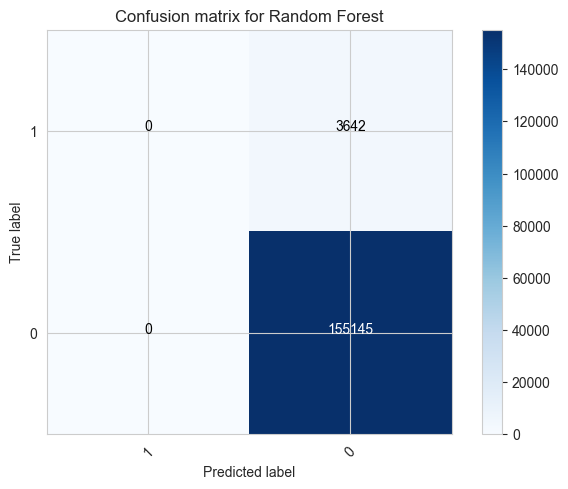

In [37]:
from sklearn.metrics import confusion_matrix

class_names = [1, 0]

y_true = predictions.select("label").toPandas()
y_pred = predictions.select("prediction").toPandas()

cm = confusion_matrix(y_true, y_pred, labels=class_names)
plot_confusion_matrix(
    cm, 
    classes=class_names,
    title='Confusion matrix for Random Forest')
plt.show()

/home/arthur/miniconda3/envs/case-ds/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
/home/arthur/miniconda3/envs/case-ds/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


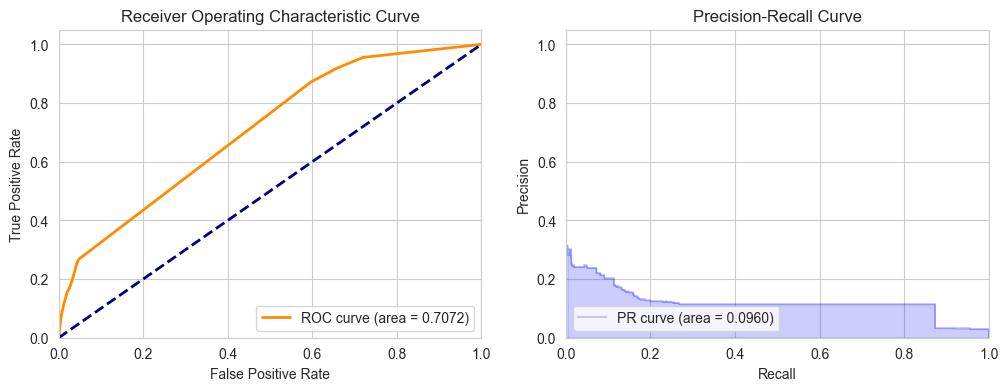

In [38]:
plot_roc_pr_curve(predictions)

## Gradient Boosting

In [40]:
from pyspark.ml import feature, classification

gbt_model = classification.GBTClassifier(featuresCol='features', labelCol='label').fit(train_data)

In [41]:
predictions = gbt_model.transform(test_data)

In [42]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

bce = BinaryClassificationEvaluator(labelCol='label', metricName='areaUnderPR')

# Finding out area under PR curve for validation dataset
bce.evaluate(predictions)

0.08886769413723172

Confusion matrix, without normalization


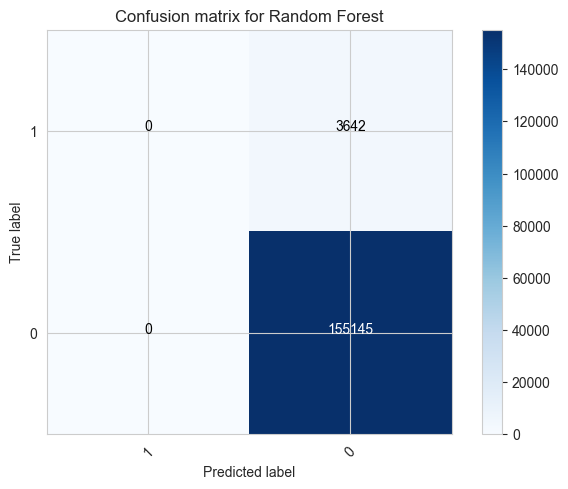

In [43]:
from sklearn.metrics import confusion_matrix

class_names = [1, 0]

y_true = predictions.select("label").toPandas()
y_pred = predictions.select("prediction").toPandas()

cm = confusion_matrix(y_true, y_pred, labels=class_names)
plot_confusion_matrix(
    cm, 
    classes=class_names,
    title='Confusion matrix for Random Forest')
plt.show()

/home/arthur/miniconda3/envs/case-ds/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
/home/arthur/miniconda3/envs/case-ds/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


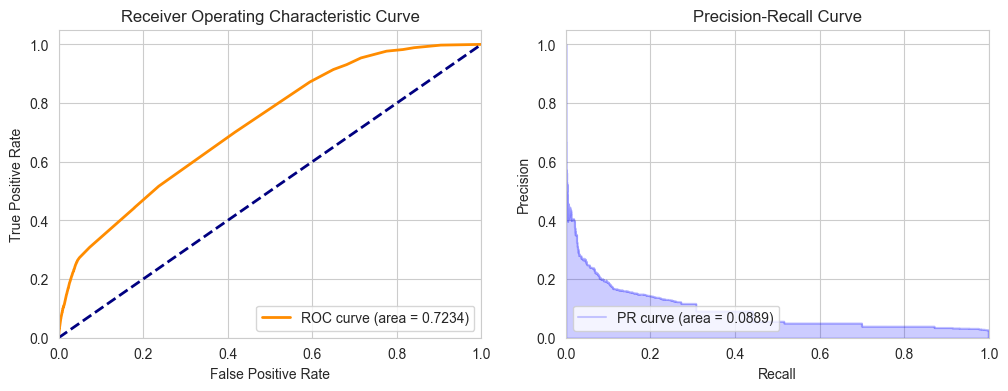

In [44]:
plot_roc_pr_curve(predictions)

## AutoEncoder

In [57]:
import torch

# Step 1: Function to separate train data into normal and abnormal
def separate_normal_abnormal(train_df):
    # Assuming 'label' indicates if it's a chargeback (1: chargeback, 0: normal)
    normal_data_df = train_df.filter(train_df["label"] == 0).select(numerical_cols)
    abnormal_data_df = train_df.filter(train_df["label"] == 1).select(numerical_cols)
    
    return normal_data_df, abnormal_data_df

# Step 2: Function to convert PySpark DataFrame to NumPy
def pyspark_to_numpy(df):
    return np.array(df.collect())

ModuleNotFoundError: No module named 'torch'

In [56]:
class TransactionDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        # Data is assumed to be a NumPy array
        self.data = torch.tensor(data, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

NameError: name 'torch' is not defined

In [67]:
def extract_features_from_vector(df, selected_features):
    feature_columns = pd.DataFrame(df['features'].tolist(), columns=selected_features)
    df_with_features = pd.concat([df, feature_columns], axis=1)
    df_with_features = df_with_features.drop(columns=['features'])
    return df_with_features

In [68]:
X_train = train_data.select("features").toPandas()
X_train = extract_features_from_vector(X_train, features_to_train)

y_train = train_data.select("label").toPandas().values.ravel()

In [69]:
X_test = test_data.select("features").toPandas()
X_test = extract_features_from_vector(X_test, features_to_train)

y_test = test_data.select("label").toPandas().values.ravel()

In [70]:
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, precision_recall_curve, fbeta_score, precision_score, recall_score

def get_metrics(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    f2 = fbeta_score(y_test, y_pred, beta=2)
    print(f"F1 Score: {f1}\n")
    print(f"F2 Score {f2}")
    print('\nTrue Positives(TP) = ', cm[0,0])
    print('\nTrue Negatives(TN) = ', cm[1,1])
    print('\nFalse Positives(FP) = ', cm[0,1])
    print('\nFalse Negatives(FN) = ', cm[1,0])

In [71]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

RandomForestClassifier()

In [72]:
importances = rf_model.feature_importances_
feature_imp_df = pd.DataFrame({'Feature': rf_model.feature_names_in_, 'Gini Importance': importances}).sort_values('Gini Importance', ascending=False) 
print(feature_imp_df)

                                      Feature  Gini Importance
4                                day_of_month         0.168120
2                       seconds_from_midnight         0.158636
12                                     season         0.107867
11                                 day_period         0.106674
9   f_total_installations_imputed_by_provider         0.099419
10         f_total_events_imputed_by_provider         0.089195
6          transaction_count_by_device_id_30d         0.087127
3                                 day_of_week         0.049385
5                                       month         0.048418
8        f_sum_values_by_device_id_3d_imputed         0.042011
7           f_sum_values_by_ilm_id_3d_imputed         0.025671
0                        mean_chargeback_rate         0.011456
1                                 hour_of_day         0.006019


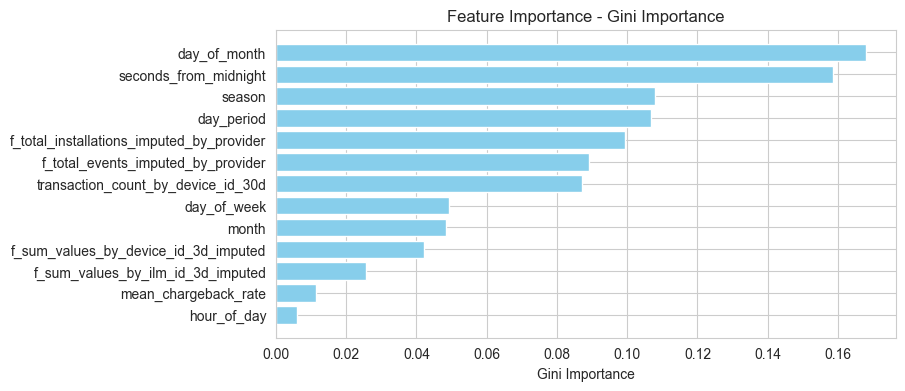

In [73]:
# Create a bar plot for feature importance
plt.figure(figsize=(8, 4))
plt.barh(feature_imp_df["Feature"], feature_imp_df["Gini Importance"], color='skyblue')
plt.xlabel('Gini Importance')
plt.title('Feature Importance - Gini Importance')
plt.gca().invert_yaxis()  # Invert y-axis for better visualization
plt.show()

## LightGBM

In [74]:
from lightgbm import LGBMClassifier


def train_lgbm(X_train, y_train, X_test, y_test, transaction_amounts, threshold=0.5):
    model = LGBMClassifier(is_unbalance=True)
    model.fit(X_train, y_train)
    
    probas = model.predict_proba(X_test)[:, 1]
    
    y_pred_thresholded = (probas >= threshold).astype(int)
    
    cm = confusion_matrix(y_test, y_pred_thresholded)
    tn, fp, fn, tp = cm.ravel()

    precision = precision_score(y_test, y_pred_thresholded)
    recall = recall_score(y_test, y_pred_thresholded)
    f1 = f1_score(y_test, y_pred_thresholded)
    

    net_profit = calculate_profit(y_test, y_pred_thresholded, transaction_amounts)
    
    metrics = {
        "True Positives (TP)": tp,
        "True Negatives (TN)": tn,
        "False Positives (FP)": fp,
        "False Negatives (FN)": fn,
        "Precision": precision,
        "Recall": recall,
        "Profit": net_profit,
        "Threshold": threshold
    }
    
    return metrics, y_pred_thresholded

def optimize_threshold(X_train, y_train, X_test, y_test, transaction_amounts, thresholds=np.arange(0.1, 1.0, 0.05)):
    best_metrics = None
    best_threshold = None
    max_net_profit = float('-inf')
    
    for threshold in thresholds:
        metrics, _ = train_lgbm(X_train, y_train, X_test, y_test, transaction_amounts, threshold=threshold)
        
        if metrics["Profit"] > max_net_profit:
            max_net_profit = metrics["Profit"]
            best_metrics = metrics
            best_threshold = threshold
    
    return best_threshold, best_metrics

In [75]:
best_th, best_metrics = optimize_threshold(X_train, y_train, X_test, y_test, test_data_amounts.toPandas().values.ravel())

[LightGBM] [Info] Number of positive: 14339, number of negative: 621536
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013767 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1649
[LightGBM] [Info] Number of data points in the train set: 635875, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.022550 -> initscore=-3.769211
[LightGBM] [Info] Start training from score -3.769211
[LightGBM] [Info] Number of positive: 14339, number of negative: 621536
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028113 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1649
[LightGBM] [Info] Number of data points in the train set: 635875, number of used features: 13
[LightGBM] [In

In [77]:
best_metrics

{'True Positives (TP)': np.int64(755),
 'True Negatives (TN)': np.int64(152259),
 'False Positives (FP)': np.int64(3142),
 'False Negatives (FN)': np.int64(2990),
 'Precision': np.float64(0.1937387734154478),
 'Recall': np.float64(0.20160213618157544),
 'Profit': np.float32(857594.25),
 'Threshold': np.float64(0.8500000000000002)}

In [57]:
# Assuming your data contains a 'provider' column with values: 'EXTERNAL_1', 'EXTERNAL_2', 'YOU'
data_external_1 = test_data.filter(F.col("provider") == "EXTERNAL_1")
data_external_2 = test_data.filter(F.col("provider") == "EXTERNAL_2")
data_you = test_data.filter(F.col("provider") == "YOU")

In [58]:
# Group by provider and chargeback, and count the occurrences
chargeback_by_provider_df = raw_data.groupBy("provider").count().toPandas()

# Pivot the data for stacked bar plotting
chargeback_by_provider_pivot = chargeback_by_provider_df.pivot(index='provider', columns='chargeback', values='count')

# Plot stacked bar
chargeback_by_provider_pivot.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Chargeback Distribution by Provider')
plt.xlabel('Provider')
plt.ylabel('Count of Transactions')
plt.xticks(rotation=0)
plt.legend(title='Chargeback')
plt.show()

109182

## Isolation Forest

In [78]:
def isolation_forest(X_train, y_train, X_test, y_test, transaction_amounts):
    iso_forest = IsolationForest(contamination="auto", random_state=SEED)
    iso_forest.fit(X_train)
    
    y_pred = iso_forest.predict(X_test)
    
    y_pred = np.where(y_pred == -1, 1, 0)
    anomaly_scores = iso_forest.decision_function(X_test)
    
    net_profit = calculate_profit(y_test, y_pred, transaction_amounts)
    
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    f1 = f1_score(y_test, y_pred)

    metrics = {
        "True Positives (TP)": tp,
        "True Negatives (TN)": tn,
        "False Positives (FP)": fp,
        "False Negatives (FN)": fn,
        "F1 Score": f1,
        "Profit": net_profit
    }
    
    return metrics

In [79]:
metrics = isolation_forest(X_train, y_train, X_test, y_test, transaction_amounts)
metrics

{'True Positives (TP)': np.int64(1387),
 'True Negatives (TN)': np.int64(135193),
 'False Positives (FP)': np.int64(20208),
 'False Negatives (FN)': np.int64(2358),
 'F1 Score': np.float64(0.10947119179163378),
 'Profit': np.float32(741008.25)}